In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 

In [2]:
os.chdir('..')

In [3]:
import helper as h
from utilsstreamlit import read_plot_info

In [4]:
#here, the lenguage and lemmatization option is chosen
netName = 'Spanish'
lemmatized = False
if lemmatized:
    iol = 'lemmatized'
    netPath = 'files/lemmatized/networks/'
    folderframe = 'files/lemmatized/dfplot/'
    saving = 'files/lemmatized/analysis/'
else:
    iol = 'inflected'
    netPath = 'files/inflected/networks/'
    folderframe = 'files/inflected/dfplot/'
    saving = 'files/inflected/analysis/'
picsdir = f'{saving}{netName}'
if not os.path.exists(picsdir):
    os.mkdir(picsdir)
fNeighborMean = True
fNeighborStd = False 
#Reading saved properties from the network
(nodeList, propertiesDict) = h.readNetworkProperties(netName, netPath, fNeighborMean, fNeighborStd); 
(includedProperties, excludedProperties) = h.findPathologicalProperties(propertiesDict);  
includedProperties

['degree',
 'eigenvectorCentrality',
 'betweennessCentrality',
 'closenessCentrality',
 'harmonicCentrality',
 'pagerank',
 'coreNumber',
 'onionLayer',
 'effectiveSize',
 'nodeCliqueNumber',
 'numberOfCliques',
 'clustering',
 'squareClustering',
 'closenessVitality',
 'constraint',
 'degree_neighborMean',
 'eigenvectorCentrality_neighborMean',
 'betweennessCentrality_neighborMean',
 'closenessCentrality_neighborMean',
 'harmonicCentrality_neighborMean',
 'pagerank_neighborMean',
 'coreNumber_neighborMean',
 'onionLayer_neighborMean',
 'effectiveSize_neighborMean',
 'nodeCliqueNumber_neighborMean',
 'numberOfCliques_neighborMean',
 'clustering_neighborMean',
 'squareClustering_neighborMean',
 'closenessVitality_neighborMean',
 'constraint_neighborMean']

In [5]:
goodkeys = [key for key in propertiesDict.keys()][:17]
goodkeys.append('clustering_neighborMean')
print(goodkeys)


['degree', 'eigenvectorCentrality', 'betweennessCentrality', 'closenessCentrality', 'harmonicCentrality', 'componentSize', 'pagerank', 'coreNumber', 'onionLayer', 'effectiveSize', 'nodeCliqueNumber', 'numberOfCliques', 'clustering', 'squareClustering', 'closenessVitality', 'constraint', 'degree_neighborMean', 'clustering_neighborMean']


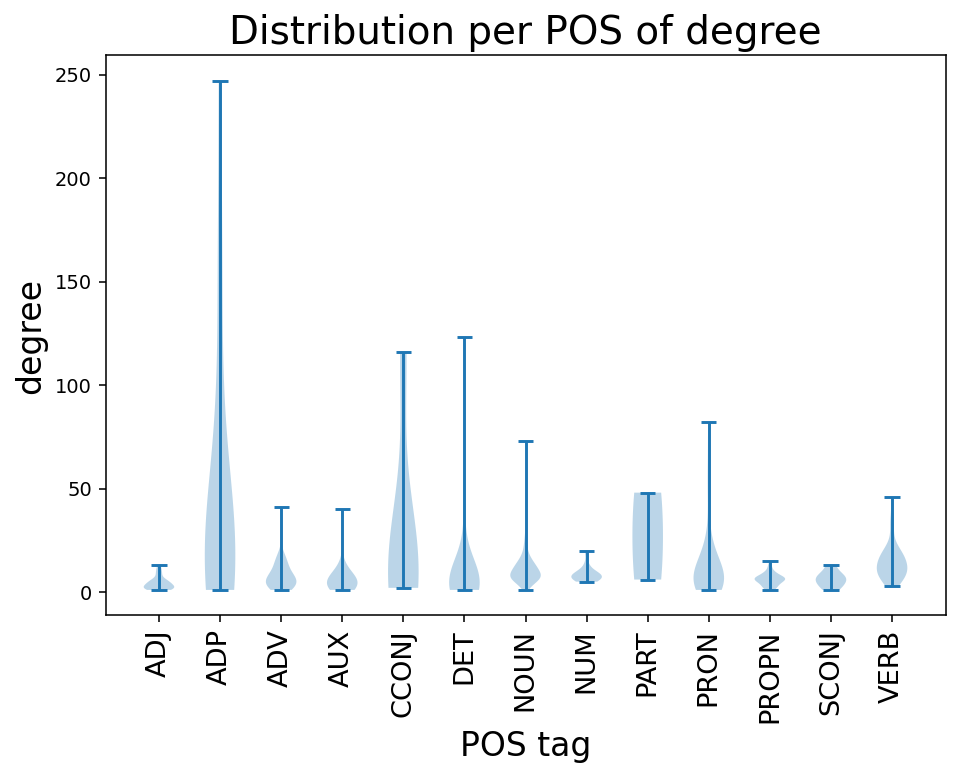

f-value is 9.621326787319648 and p-value is 7.164451539798529e-17 for degree property


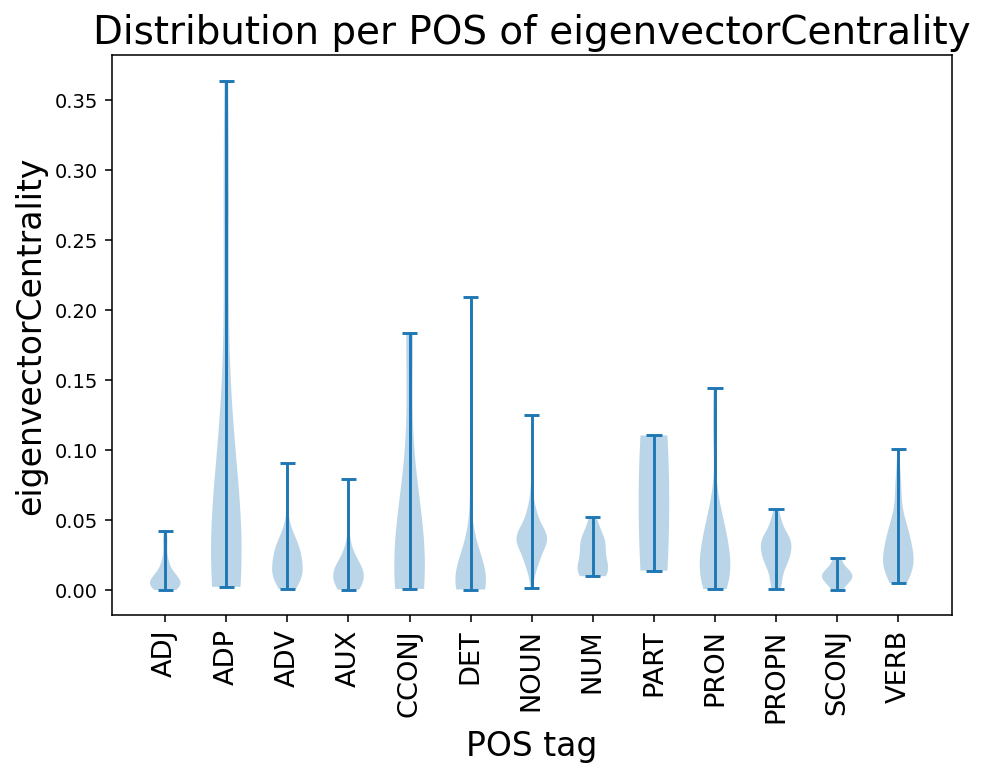

f-value is 8.432470409990879 and p-value is 1.430574243790459e-14 for eigenvectorCentrality property


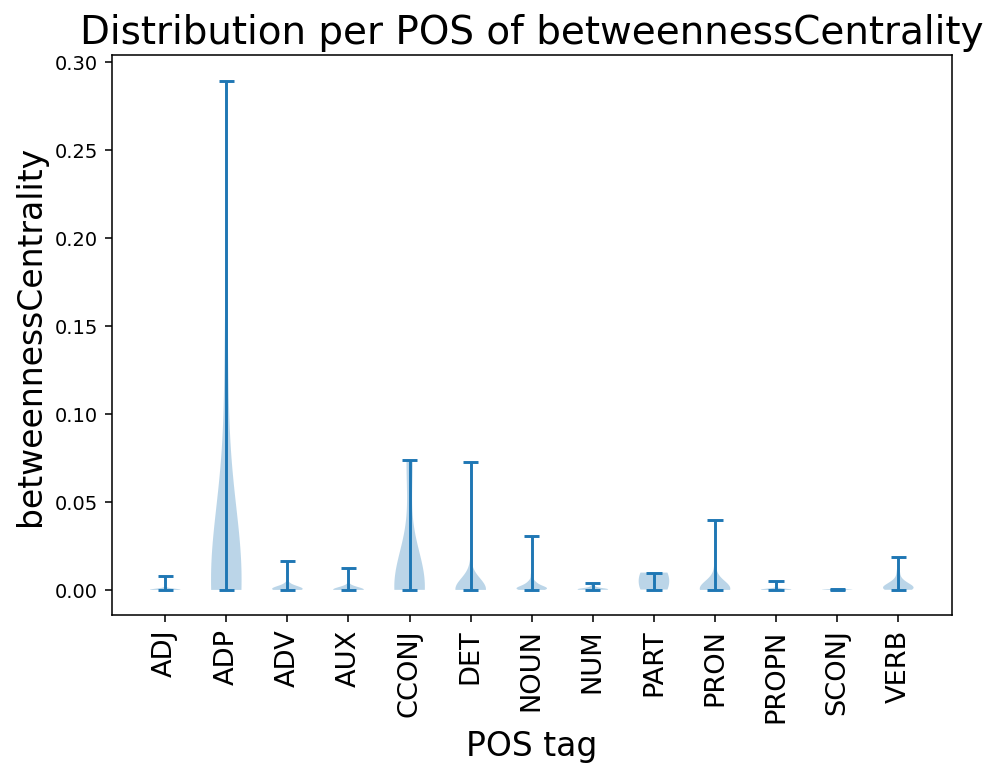

f-value is 6.754948689512473 and p-value is 2.7349951180128933e-11 for betweennessCentrality property


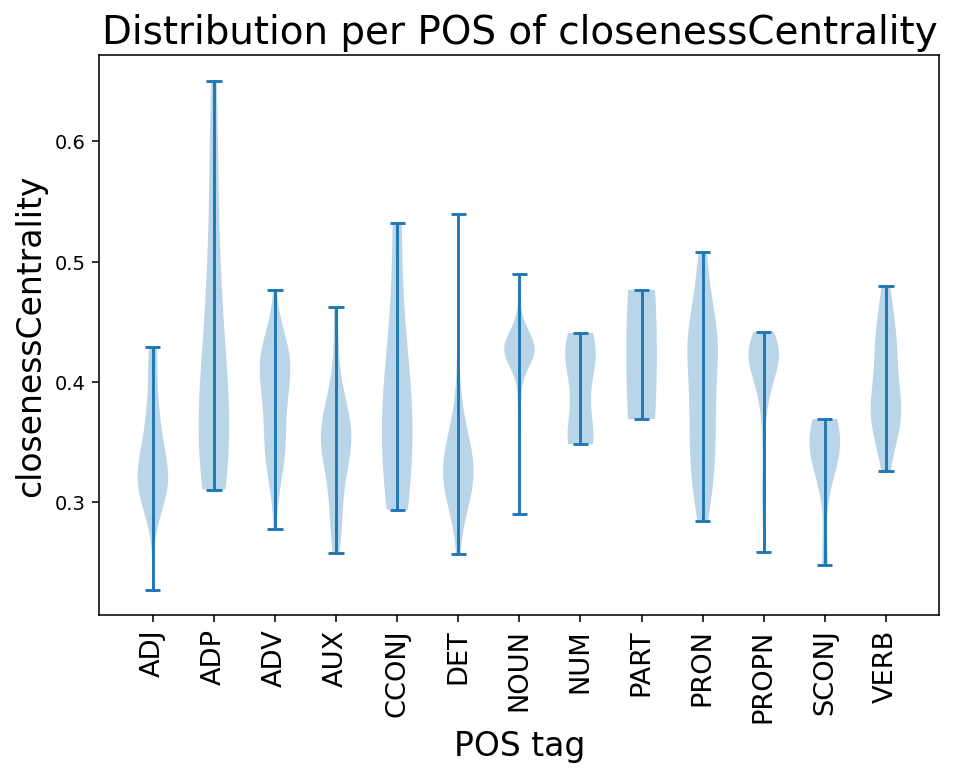

f-value is 19.066890104310385 and p-value is 5.906508427229467e-34 for closenessCentrality property


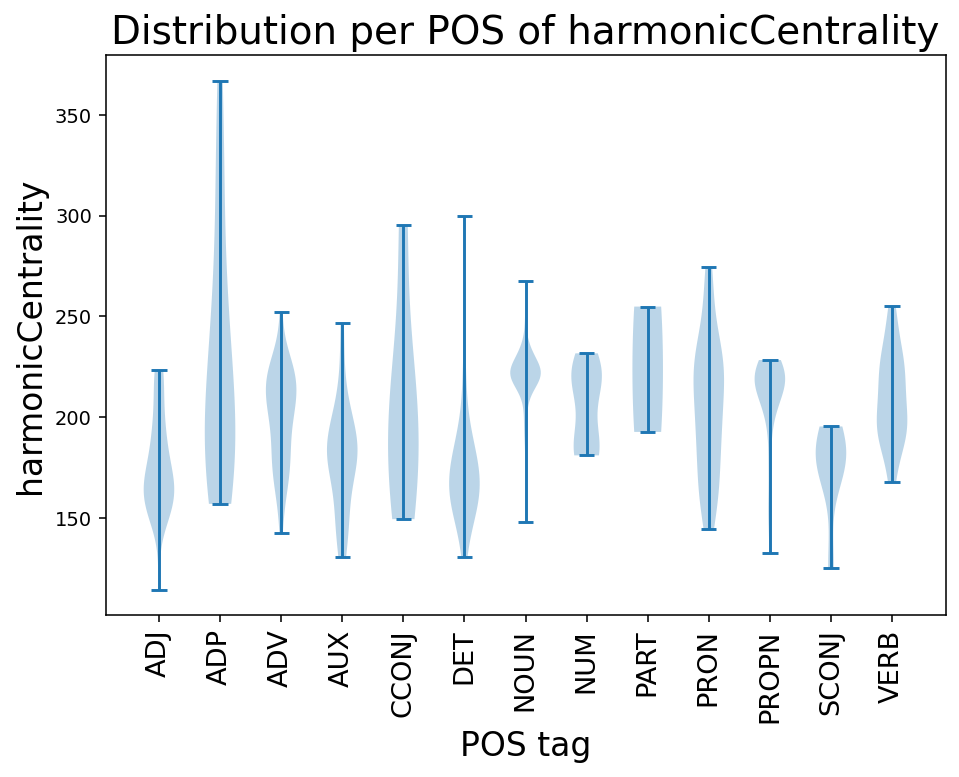

f-value is 17.361716641567167 and p-value is 4.8817912192775655e-31 for harmonicCentrality property


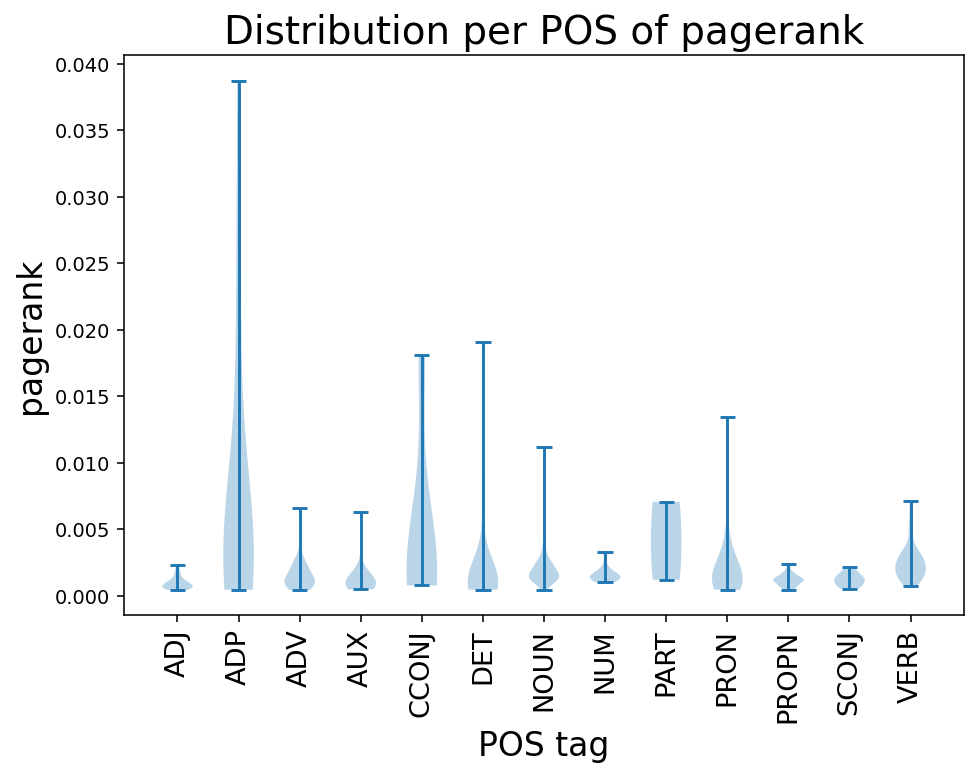

f-value is 9.711478809263934 and p-value is 4.806882036103777e-17 for pagerank property


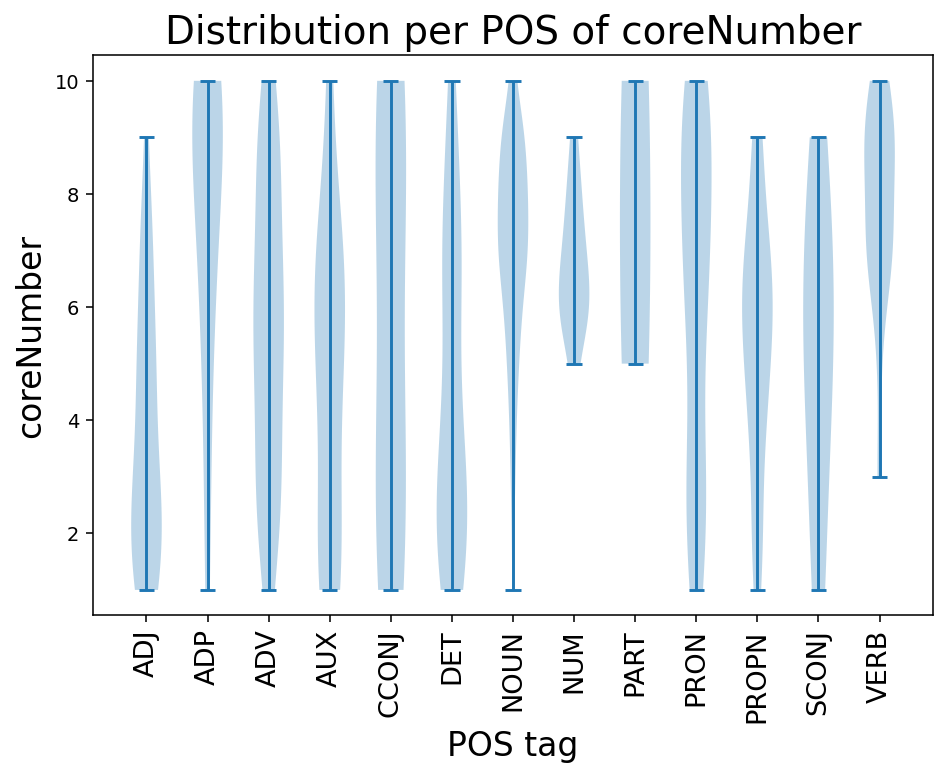

f-value is 10.87702567048652 and p-value is 2.8637952304624723e-19 for coreNumber property


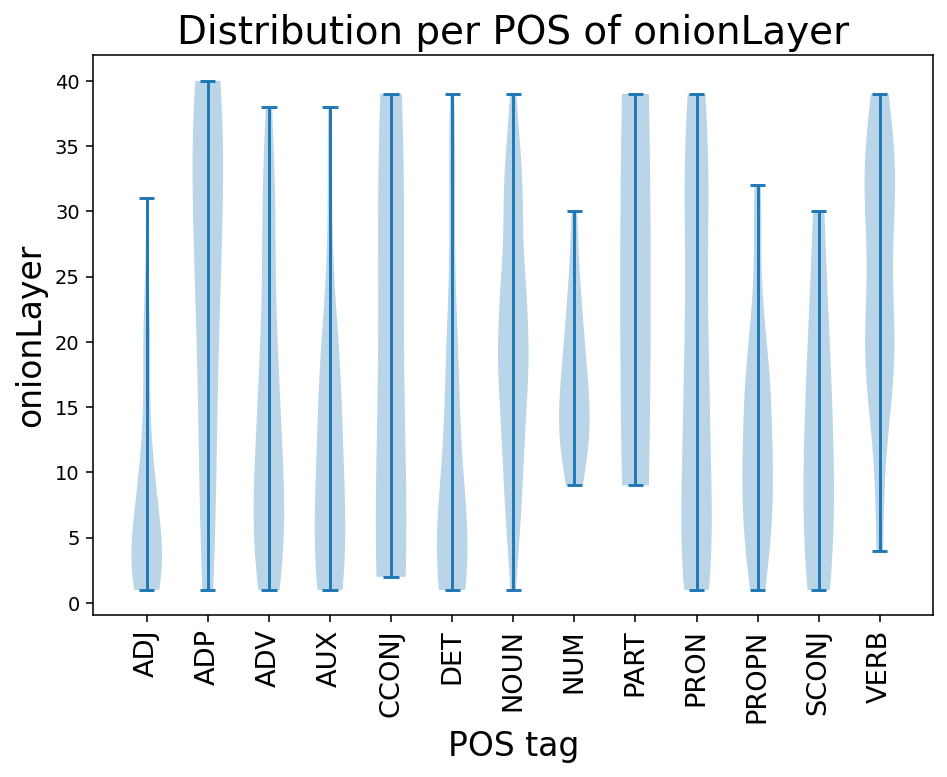

f-value is 9.913252940348755 and p-value is 1.9704431131065243e-17 for onionLayer property


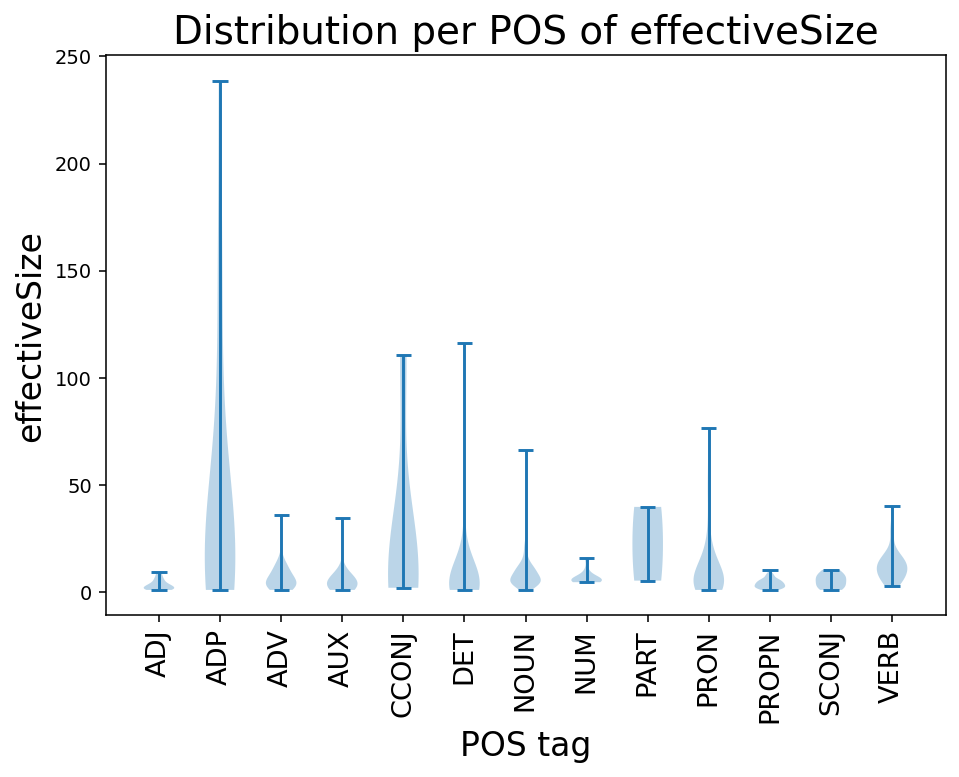

f-value is 10.244607554289681 and p-value is 4.575443879901751e-18 for effectiveSize property


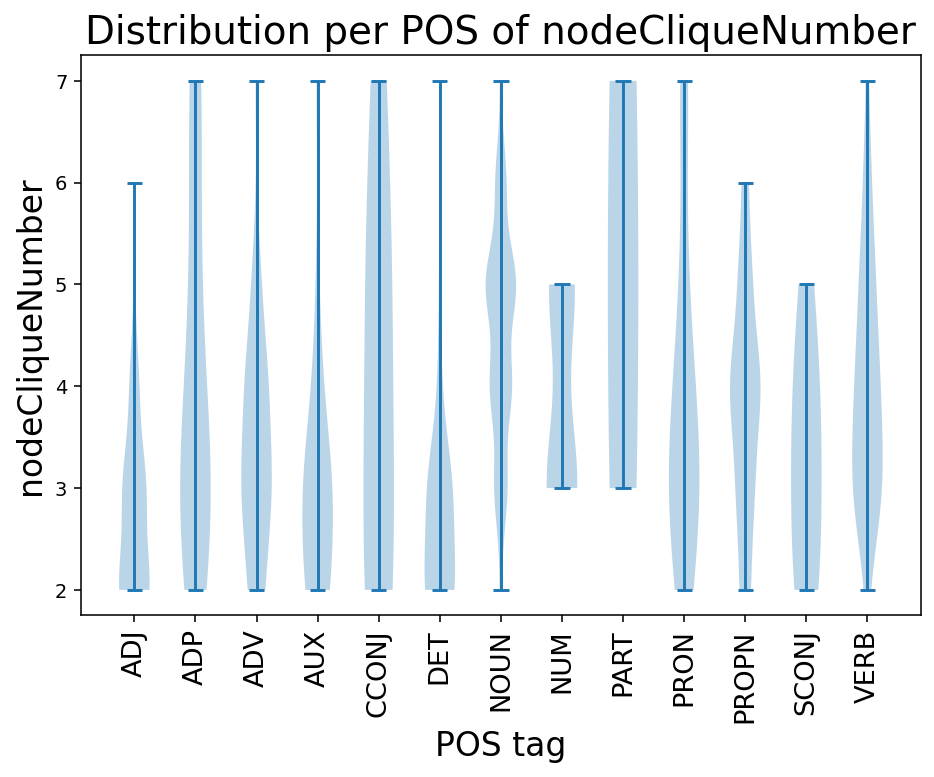

f-value is 11.555769852810748 and p-value is 1.4985061300605923e-20 for nodeCliqueNumber property


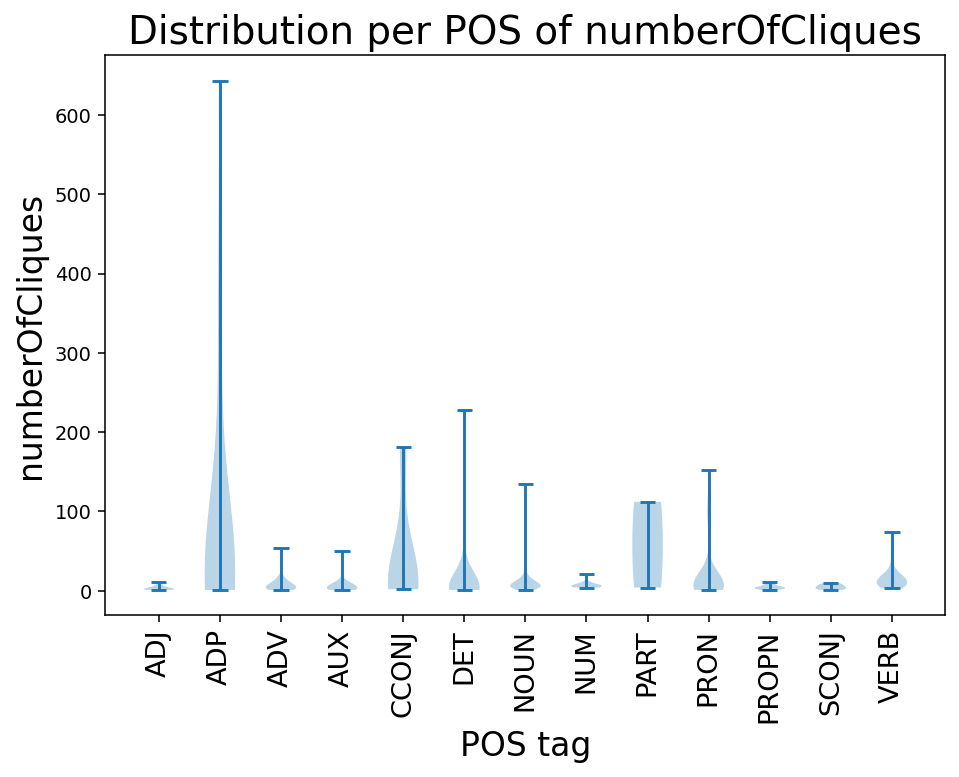

f-value is 8.116544767534888 and p-value is 5.900786554077779e-14 for numberOfCliques property


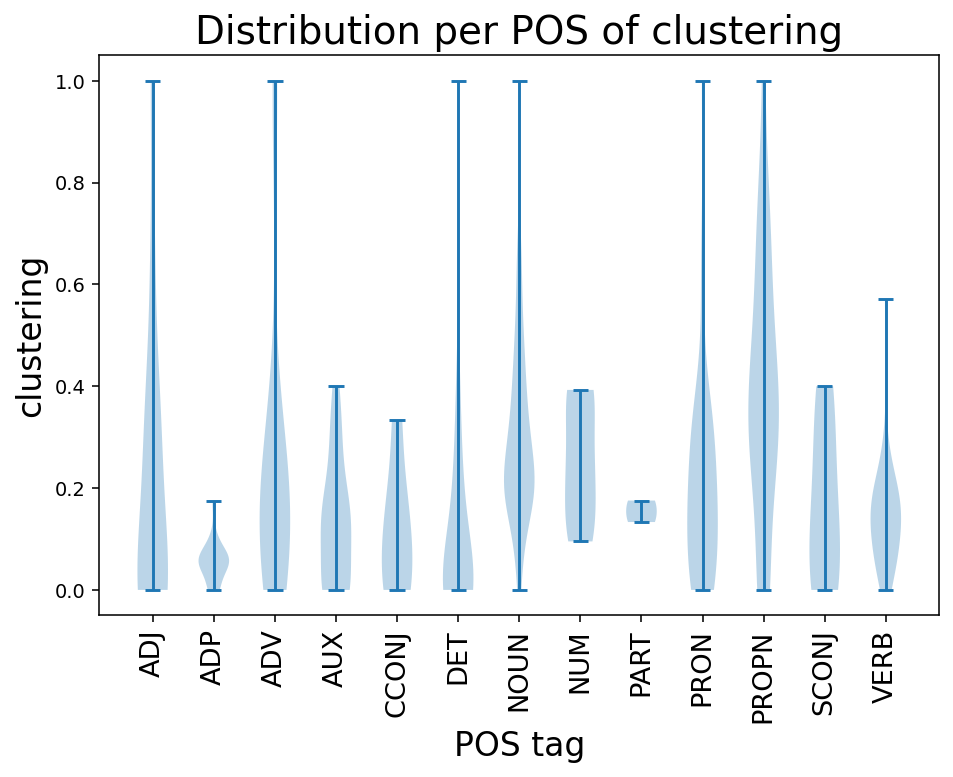

f-value is 8.29963839856356 and p-value is 2.5946042646203033e-14 for clustering property


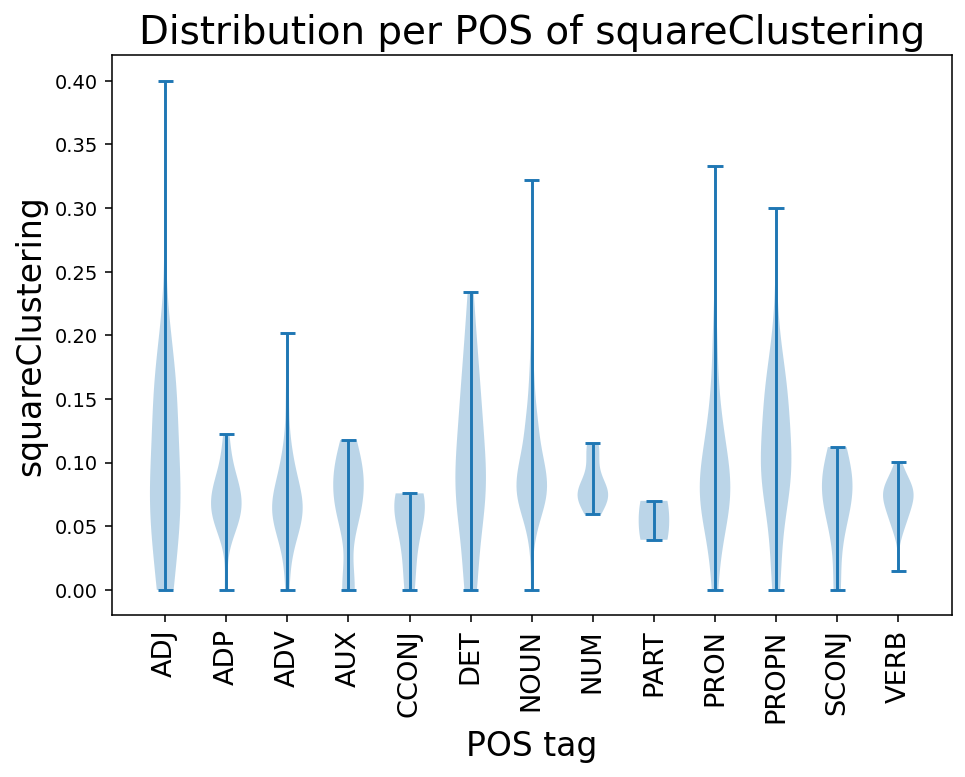

f-value is 3.348552955010022 and p-value is 0.00010564510495954339 for squareClustering property


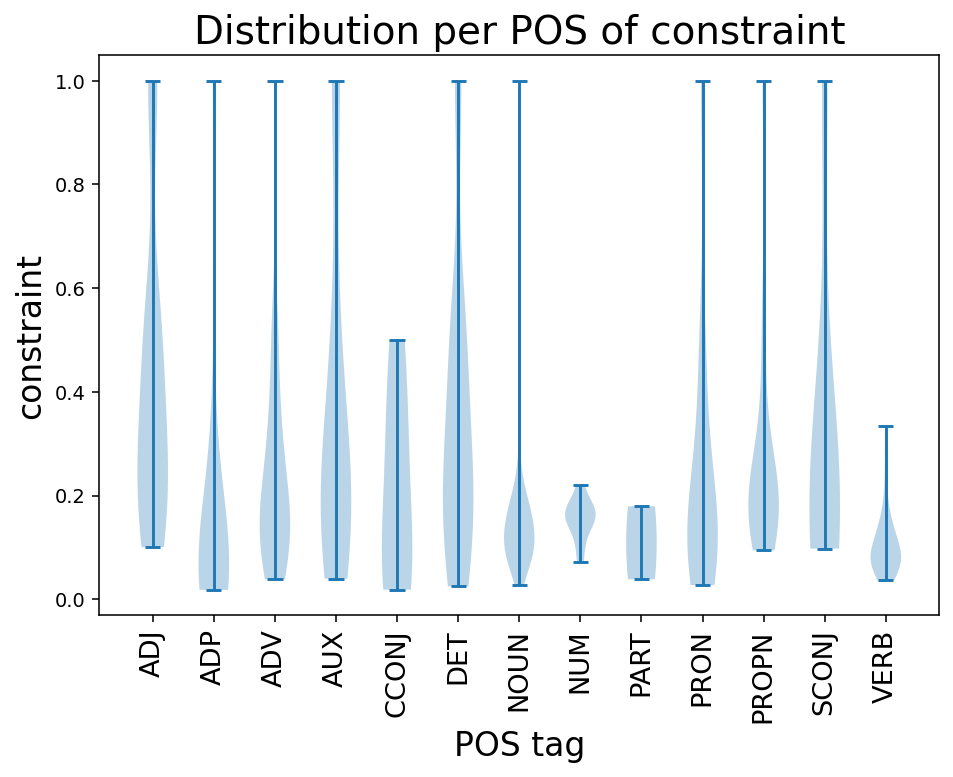

f-value is 8.76755323572997 and p-value is 3.1955657992176507e-15 for constraint property


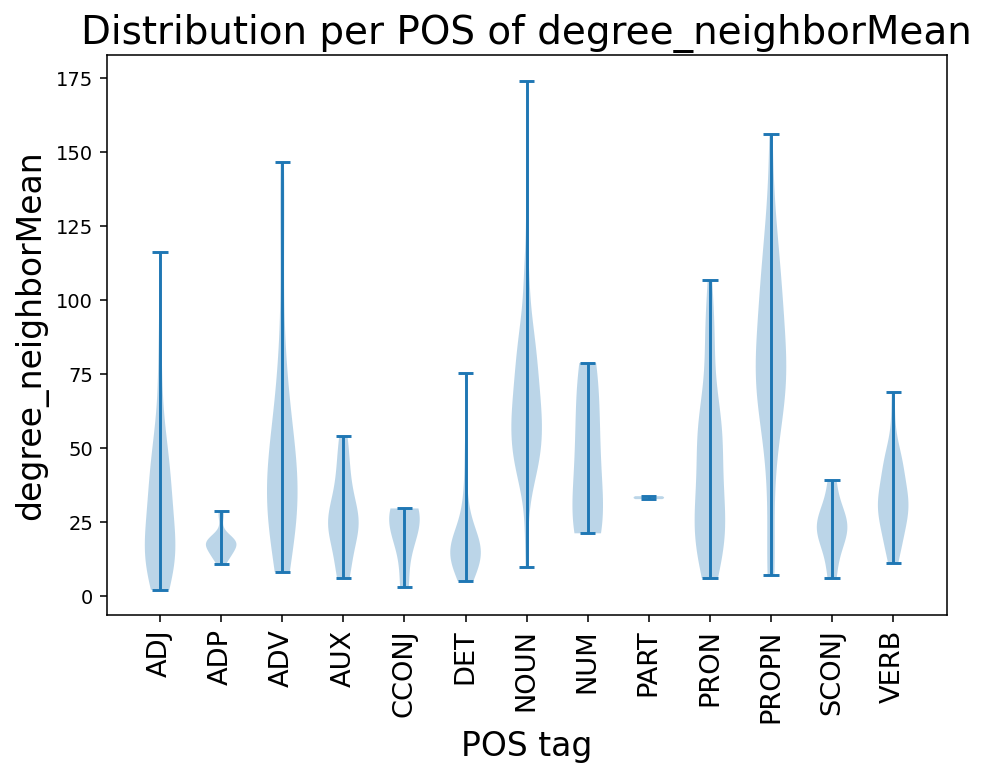

f-value is 27.19596804208876 and p-value is 6.413153948670385e-47 for degree_neighborMean property


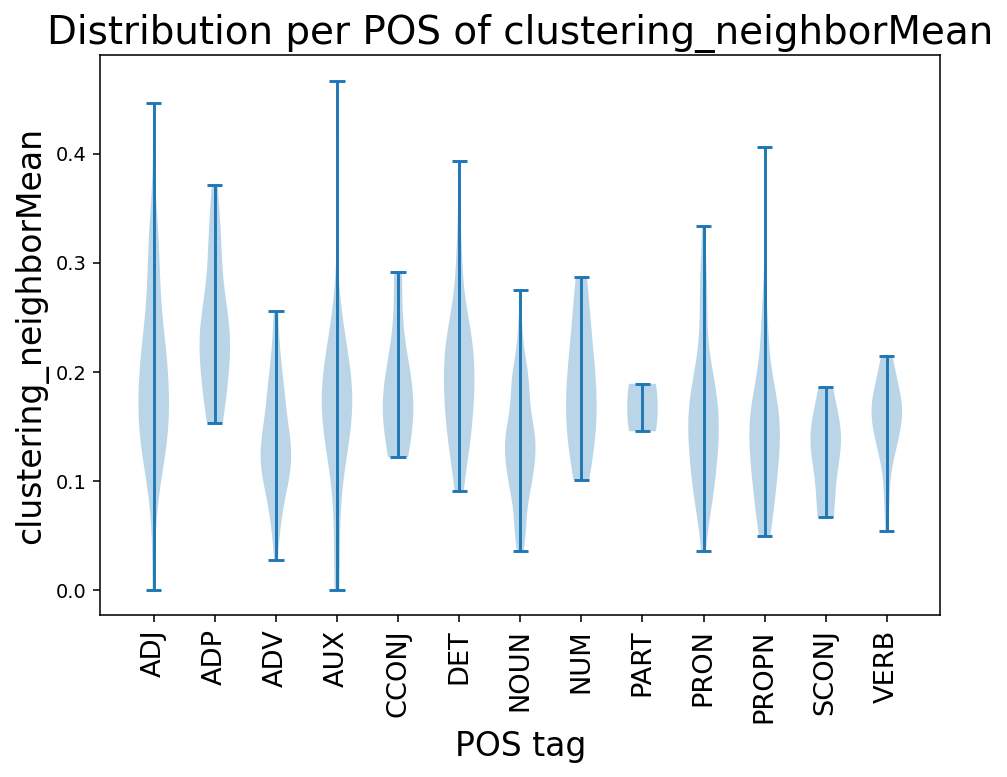

f-value is 8.477359617863197 and p-value is 1.1700272463702249e-14 for clustering_neighborMean property


In [6]:
from msilib.schema import Component
import scipy.stats as stats

#Starting by eliminating closeness vitality, which is probably broken

goodprops = {key:propertiesDict[key] for key in goodkeys if key not in ['closenessVitality','componentSize']}
#loading our dataframes with all the  info
dfplot = read_plot_info(netName,0,iol)
#geting our pos tags
postags = dfplot.groupby(by = 'POS').mean().index
#getting our list of nodes
from utils import csv2df,load_network,plotly_graph
import networkx as nx
langframe = csv2df(f'files/{iol}/dataframes/{netName}.csv')
mostfreq =langframe.unique_id.to_list()
thisNetwork = load_network(f'files/{iol}/dictionaries/{netName}.json')
thisNetwork=thisNetwork.subgraph(mostfreq)
Gcc = sorted(nx.connected_components(thisNetwork), key=len, reverse=True); 
thisNetwork = nx.Graph(thisNetwork.subgraph(Gcc[0]));
nodeList = thisNetwork.nodes()
flist = []
plist = []
for key in goodprops.keys():
    dfanova = pd.DataFrame()
    prop = goodprops[key]
    zipdict = dict(zip(nodeList,prop))
    orderednodes = dfplot['id_palabra'].to_list()
    #adding node properties to our dataframe as columns
    dfplot[key] = pd.Series([zipdict[node] for node in orderednodes])
    valuesperpos = []
    #creating the distributions per pos and per tag
    for tag in postags:
        values = dfplot[dfplot['POS'] == tag][key].to_list()
        valuesperpos.append(values)
        
    #plotting the results
    fig = plt.figure(dpi = 140)
    ax = fig.add_axes([0,0,1,1])
    bp = ax.violinplot(valuesperpos)
    x = np.arange(len(postags)+1)
    plt.xticks(x[1:],postags,size=14,rotation = 90)
    plt.title(f'Distribution per POS of {key}',fontsize = 20)
    plt.xlabel('POS tag', fontsize = 17)
    plt.ylabel(key,fontsize = 17)
    finaldir = picsdir + '/violinperpos'
    if not os.path.exists(finaldir):
        os.mkdir(finaldir)
    plt.savefig(f'{finaldir}/{key}.pdf',bbox_inches = 'tight',dpi = 140)
    plt.show()
    fvalue,pvalue = stats.f_oneway(valuesperpos[0], valuesperpos[1], valuesperpos[2], valuesperpos[3], valuesperpos[4], 
    valuesperpos[5], valuesperpos[6], valuesperpos[7], valuesperpos[8], valuesperpos[9], valuesperpos[10], 
    valuesperpos[11], valuesperpos[12] )
    print(f"f-value is {fvalue} and p-value is {pvalue} for {key} property")
    flist.append(fvalue)
    plist.append(pvalue)
dfvil = pd.DataFrame()
dfvil['prop'] = [prop for prop in goodprops.keys()]   
dfvil['f-value'] = flist
dfvil['p-value'] = plist
dfvil.to_csv('p_f_values_pos.csv')
    



In [7]:
dfplot.groupby(by=['nc5','POS']).count()

id_palabra  palabra  language  ranking  lemmatized  pc1  pc2  pc3  \
nc5 POS                                                                        
1   ADJ             5        5         5        5           5    5    5    5   
    ADP             1        1         1        1           1    1    1    1   
    AUX             4        4         4        4           4    4    4    4   
    CCONJ           1        1         1        1           1    1    1    1   
    DET             4        4         4        4           4    4    4    4   
    NOUN            1        1         1        1           1    1    1    1   
    PRON            3        3         3        3           3    3    3    3   
    PROPN           3        3         3        3           3    3    3    3   
    SCONJ           1        1         1        1           1    1    1    1   
2   ADJ            31       31        31       31          31   31   31   31   
    ADP            10       10        10       10          10   10   10   10   
    ADV            18       18        18       18          18   18   18   18   
    AUX            17       17        17       17          17   17   17   17   
    CCONJ           2        2         2        2           2    2    2    2   
    DET            28       28        28       28          28   28   28   28   
    NOUN           13       13        13       13          13   13   13   13   
    NUM             6        6         6        6           6    6    6    6   
    PART            1        1         1        1           1    1    1    1   
    PRON           18       18        18       18          18   18   18   18   
    PROPN           8        8         8        8           8    8    8    8   
    SCONJ           6        6         6        6           6    6    6    6   
    VERB           21       21        21       21          21   21   21   21   
3   ADP             3        3         3        3           3    3    3    3   
    CCONJ           1        1         1        1           1    1    1    1   
    DET             1        1         1        1           1    1    1    1   
4   ADJ             2        2         2        2           2    2    2    2   
    ADP             4        4         4        4           4    4    4    4   
    ADV             4        4         4        4           4    4    4    4   
    AUX             2        2         2        2           2    2    2    2   
    CCONJ           2        2         2        2           2    2    2    2   
    DET             1        1         1        1           1    1    1    1   
    NOUN           74       74        74       74          74   74   74   74   
    NUM             2        2         2        2           2    2    2    2   
    PART            1        1         1        1           1    1    1    1   
    PRON           15       15        15       15          15   15   15   15   
    PROPN           5        5         5        5           5    5    5    5   
    VERB           10       10        10       10          10   10   10   10   
5   ADJ             5        5         5        5           5    5    5    5   
    ADV            13       13        13       13          13   13   13   13   
    DET             1        1         1        1           1    1    1    1   
    NOUN           89       89        89       89          89   89   89   89   
    NUM             4        4         4        4           4    4    4    4   
    PRON            9        9         9        9           9    9    9    9   
    PROPN          43       43        43       43          43   43   43   43   
    VERB            1        1         1        1           1    1    1    1   

           rgb1  rgb2  ...  coreNumber  onionLayer  effectiveSize  \
nc5 POS                ...                                          
1   ADJ       5     5  ...           5           5              5   
    ADP       1     1  ...           1     

In [8]:
postags = dfplot.groupby(by = 'POS').mean().index


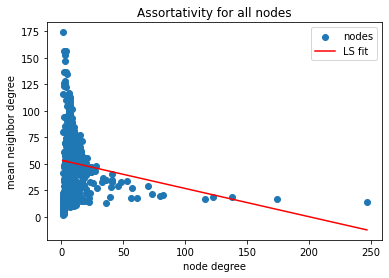

In [9]:
from sklearn.linear_model import LinearRegression
deg_plot = np.array(dfplot['degree'].to_list()).reshape((-1,1))
deg_mean_plot = np.array(dfplot['degree_neighborMean'].to_list())
model = LinearRegression()
model.fit(deg_plot,deg_mean_plot)
r_sq = model.score(deg_plot,deg_mean_plot)
y_pred = deg_plot*model.coef_ + model.intercept_
fig = plt.figure()
plt.scatter(deg_plot,deg_mean_plot)
plt.plot(deg_plot,y_pred,color = 'r')
plt.legend(['nodes','LS fit'])
plt.title(f'Assortativity for all nodes')
plt.xlabel('node degree')
plt.ylabel('mean neighbor degree')
plt.savefig(f'files/{iol}/analysis/{netName}/assortativity.png',bbox_inches = 'tight',dpi = 200)

The slope for ADJ is 2.4820662504150257;
The slope for ADP is -0.0029194932840287094;
The slope for ADV is -1.0643396328109196;
The slope for AUX is 0.34430584886022525;
The slope for CCONJ is -0.033213531521185946;
The slope for DET is 0.0010273766356342553;
The slope for NOUN is -1.4175351226509563;
The slope for NUM is 0.4833515407495;
The slope for PART is -0.023809523809523805;
The slope for PRON is -0.24733280166954352;
The slope for PROPN is 0.6719699149709828;
The slope for SCONJ is 0.45135016025641006;
The slope for VERB is 0.030791511157990035;


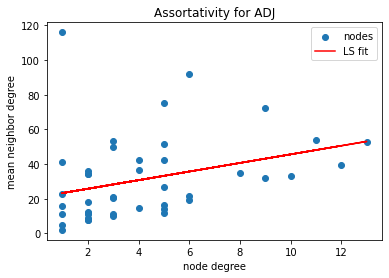

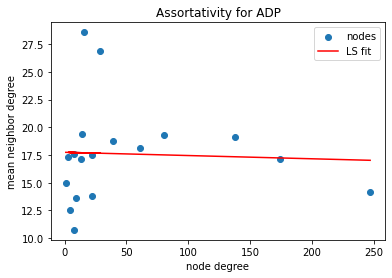

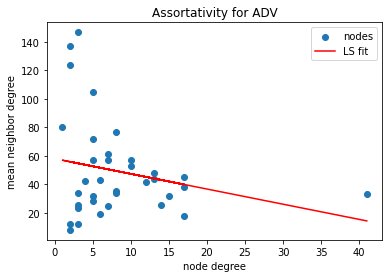

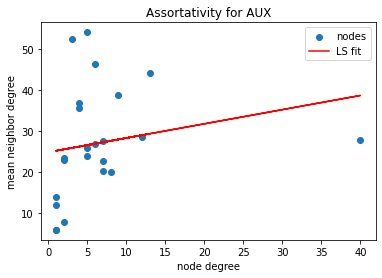

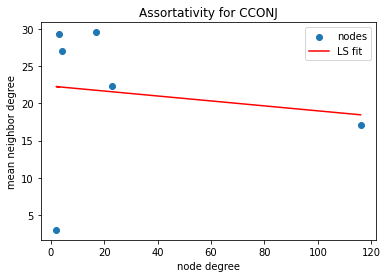

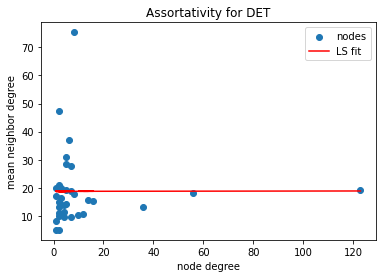

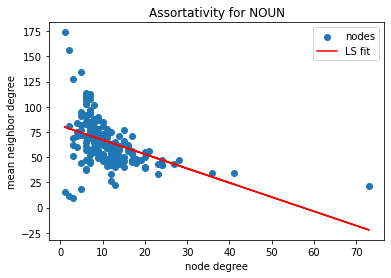

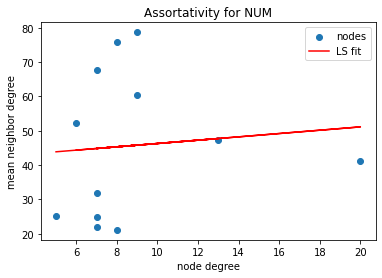

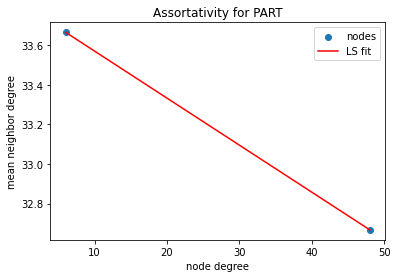

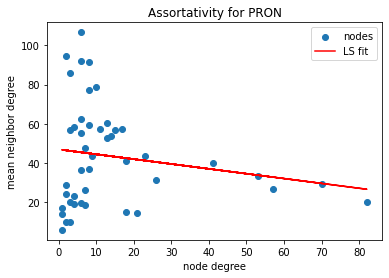

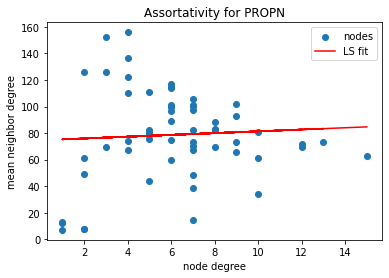

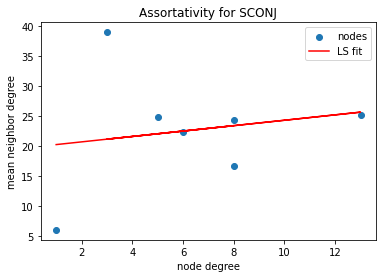

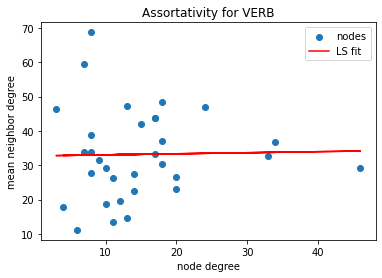

In [15]:
#Comparing degree of each node with its neighbours to check for assortativity
from sklearn.linear_model import LinearRegression
corrs = []
for tag in postags:
    deg_plot = np.array(dfplot[dfplot['POS']==tag]['degree'].to_list()).reshape((-1,1))
    deg_mean_plot = np.array(dfplot[dfplot['POS']==tag]['degree_neighborMean'].to_list())
    model = LinearRegression()
    model.fit(deg_plot,deg_mean_plot)
    r_sq = model.score(deg_plot,deg_mean_plot)
    y_pred = deg_plot*model.coef_ + model.intercept_
    corr = np.corrcoef(np.array(deg_plot).reshape((1,-1)),np.array(deg_mean_plot).reshape((1,-1)))[0,1]
    corrs.append(corr)
    fig = plt.figure()
    plt.scatter(deg_plot,deg_mean_plot)
    plt.plot(deg_plot,y_pred,color = 'r')
    plt.legend(['nodes','LS fit'])
    plt.title(f'Assortativity for {tag}')
    plt.xlabel('node degree')
    plt.ylabel('mean neighbor degree')
    finaldir = picsdir+'/assortperpos'
    if not os.path.exists(finaldir):
        os.mkdir(finaldir)
    if tag != 'AUX':
        fig.savefig(f'{finaldir}/{tag}.pdf',bbox_inches = 'tight')
    else:
        fig.savefig(f'{finaldir}/auxi.pdf',bbox_inches = 'tight')
    print(f'The slope for {tag} is {model.coef_[0]};')

In [11]:
np.corrcoef(np.array(deg_plot).reshape((1,-1)),np.array(deg_mean_plot).reshape((1,-1)))[0,1]

0.021496652732612108

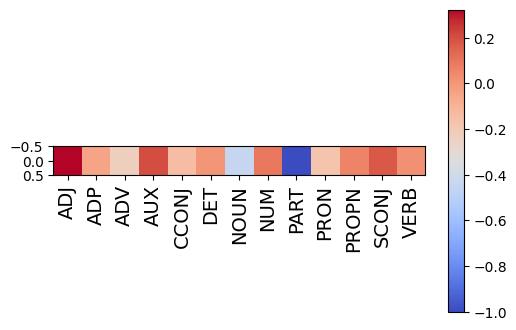

In [12]:

plt.figure(dpi=100); 
plt.imshow(np.array(corrs).reshape(1,-1), interpolation="none", cmap="coolwarm"); 
x = np.arange(len(postags))
plt.xticks(x, postags,fontsize = 14,rotation = 90)
plt.colorbar(); 

In [13]:
dfplot[dfplot['nc5'] == 3][['degree','palabra']]

degree palabra
0   247.0      de
1   123.0      el
2   116.0       y
3   174.0       a
4   138.0      en

The slope for OuterPeriphery is 0.3469263676119929;
The slope for InnerPeriphery is -0.09588989005391953;
The slope for SuperCore is -0.03217888939663728;
The slope for InerConnectors is -0.506343693532208;
The slope for OuterConnectors is -3.808383236126431;


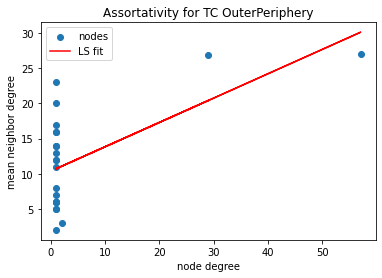

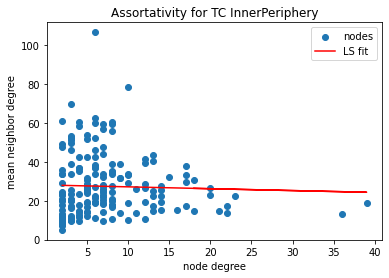

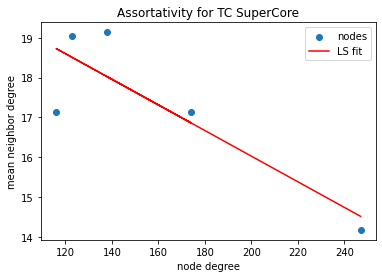

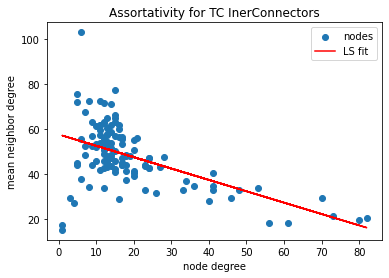

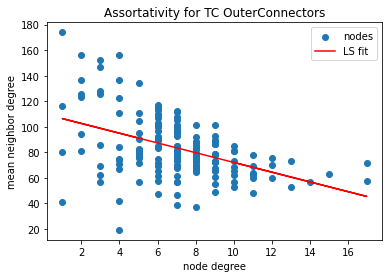

In [16]:
legendgraph = {1:'OuterPeriphery',2:'InnerPeriphery', 3:'SuperCore',4:'InerConnectors',5:'OuterConnectors'}
corrs_tc = []
for tc in range(1,6,1):
    deg_plot = np.array(dfplot[dfplot['nc5']==tc]['degree'].to_list()).reshape((-1,1))
    deg_mean_plot = np.array(dfplot[dfplot['nc5']==tc]['degree_neighborMean'].to_list())
    model = LinearRegression()
    model.fit(deg_plot,deg_mean_plot)
    r_sq = model.score(deg_plot,deg_mean_plot)
    y_pred = deg_plot*model.coef_ + model.intercept_
    corr = np.corrcoef(np.array(deg_plot).reshape((1,-1)),np.array(deg_mean_plot).reshape((1,-1)))[0,1]
    corrs_tc.append(corr)
    fig = plt.figure()
    plt.scatter(deg_plot,deg_mean_plot)
    plt.plot(deg_plot,y_pred,color = 'r')
    plt.legend(['nodes','LS fit'])
    plt.title(f'Assortativity for TC {legendgraph[tc]}')
    plt.xlabel('node degree')
    plt.ylabel('mean neighbor degree')
    finaldir = picsdir+'/assortpertc'
    if not os.path.exists(finaldir):
        os.mkdir(finaldir)
    fig.savefig(f'{finaldir}/{tc}.png',bbox_inches = 'tight',dpi=200)
    print(f'The slope for {legendgraph[tc]} is {model.coef_[0]};')
    

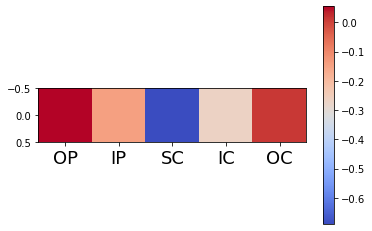

In [13]:
tc_names = ['OP','IP','SC','IC','OC']
plt.figure(); 
plt.imshow(np.array(corrs_tc).reshape(1,-1), interpolation="none", cmap="coolwarm"); 
x = np.arange(len(tc_names))
plt.xticks(x, tc_names,fontsize = 18)
plt.colorbar(); 

In [14]:
import networkx as nx
from pylab import colorbar
from matplotlib.lines import Line2D
import plotly.io as pio
pio.kaleido.scope.mathjax = None
#plotting the network, standard procedure for loading them up
from utils import csv2df,load_network,plotly_graph
langframe = csv2df(f'files/{iol}/dataframes/{netName}.csv')
mostfreq =langframe.unique_id.to_list()
thisNetwork = load_network(f'files/{iol}/dictionaries/{netName}.json')
thisNetwork=thisNetwork.subgraph(mostfreq)
Gcc = sorted(nx.connected_components(thisNetwork), key=len, reverse=True); 
thisNetwork = nx.Graph(thisNetwork.subgraph(Gcc[0]));
#Now we have to follow the order of g.nodes(), so we will have to rearrange
#the colors in the dataframe in that order
nodeList = [int(node) for node in thisNetwork.nodes()]
dictpalabras = dict(zip(dfplot['id_palabra'].to_list(),dfplot['palabra'].to_list()))
realpalabras = [dictpalabras[node] for node in nodeList]
colors2 = dict(zip(dfplot['id_palabra'].to_list(),dfplot['nc2']))
colors3 = dict(zip(dfplot['id_palabra'].to_list(),dfplot['nc3']))
colors4 = dict(zip(dfplot['id_palabra'].to_list(),dfplot['nc4']))
colors5 = dict(zip(dfplot['id_palabra'].to_list(),dfplot['nc5']))
realcolors2 = [colors2[node] for node in nodeList]
realcolors3 = [colors3[node] for node in nodeList]
realcolors4 = [colors4[node] for node in nodeList]
realcolors5 = [colors5[node] for node in nodeList]
colors2 = {1:'b',2:'g',3:'r',4:'c',5:'m'}
truecolors2 = [colors2[tc] for tc in realcolors2]
truecolors3 = [colors2[tc] for tc in realcolors3]
truecolors4 = [colors2[tc] for tc in realcolors4]
truecolors5 = [colors2[tc] for tc in realcolors5]
colorsinverse2 = {value:key for key,value in colors2.items()}
for colorset in [realcolors2,realcolors3, realcolors4,realcolors5]:
    plotly_graph(thisNetwork,colorset,realpalabras,True,picsdir)
    


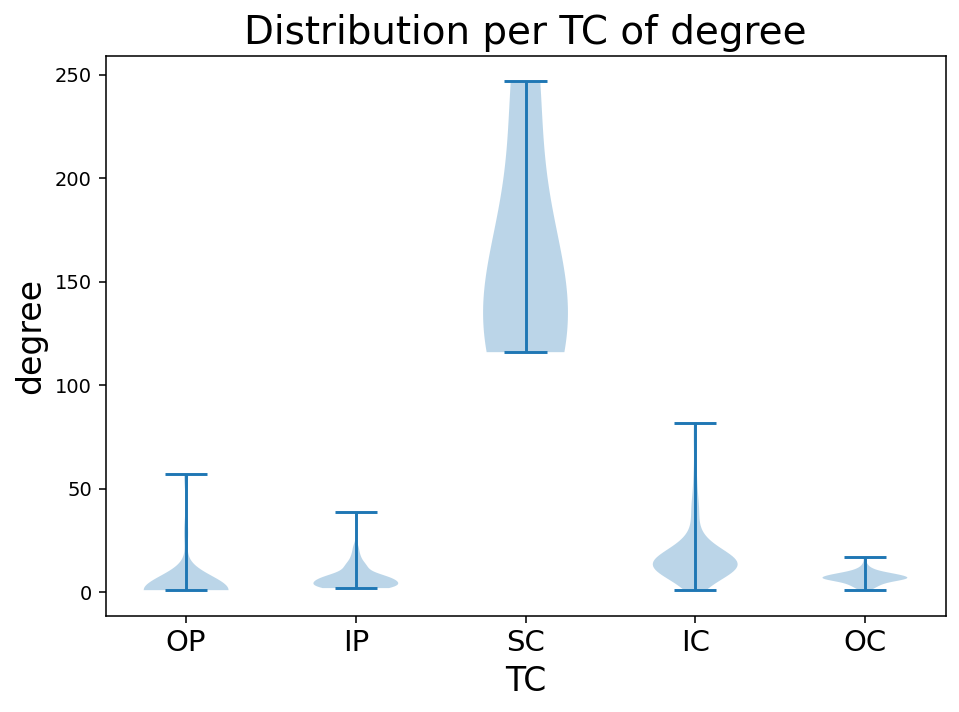

f-value is 302.01807293950145 and p-value is 1.3105144033359155e-130 for degree property


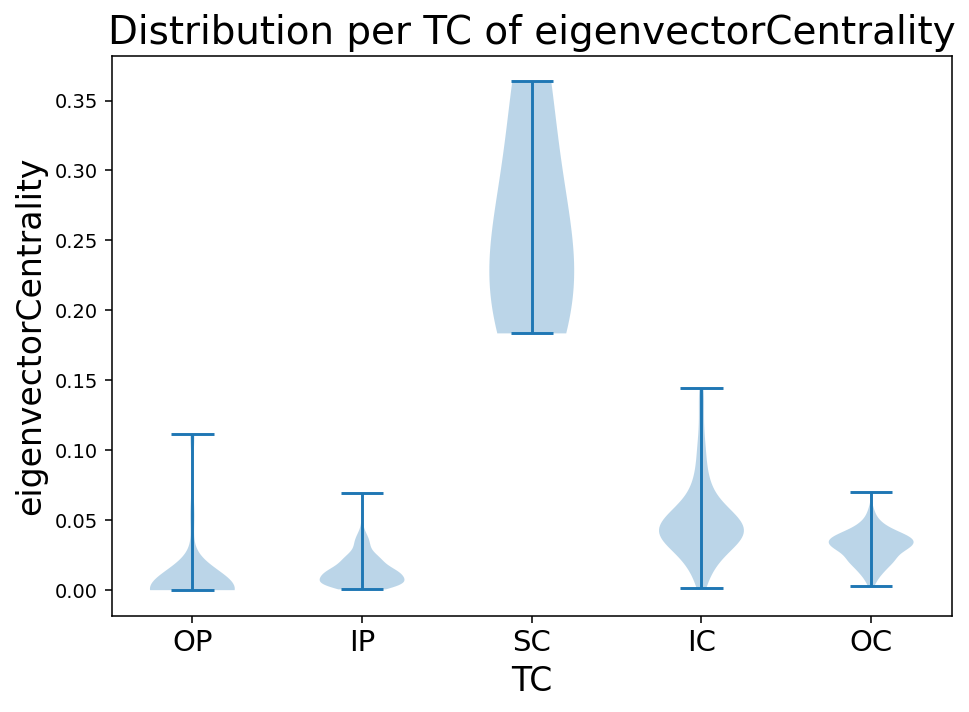

f-value is 265.543915299963 and p-value is 4.423912376546543e-121 for eigenvectorCentrality property


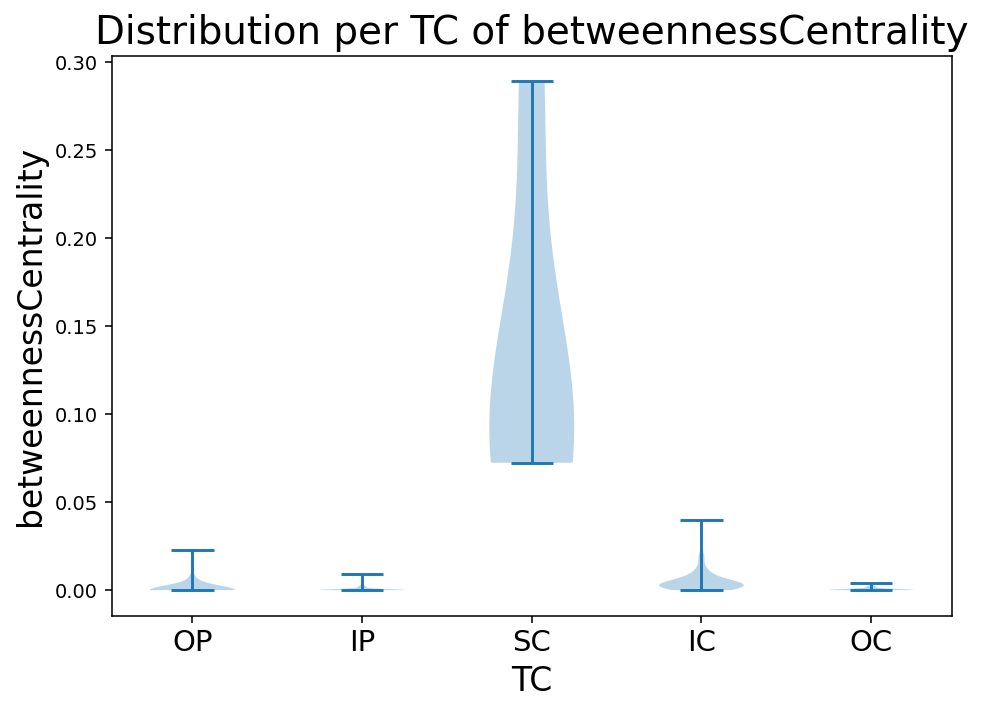

f-value is 264.16940307879185 and p-value is 1.052286280403479e-120 for betweennessCentrality property


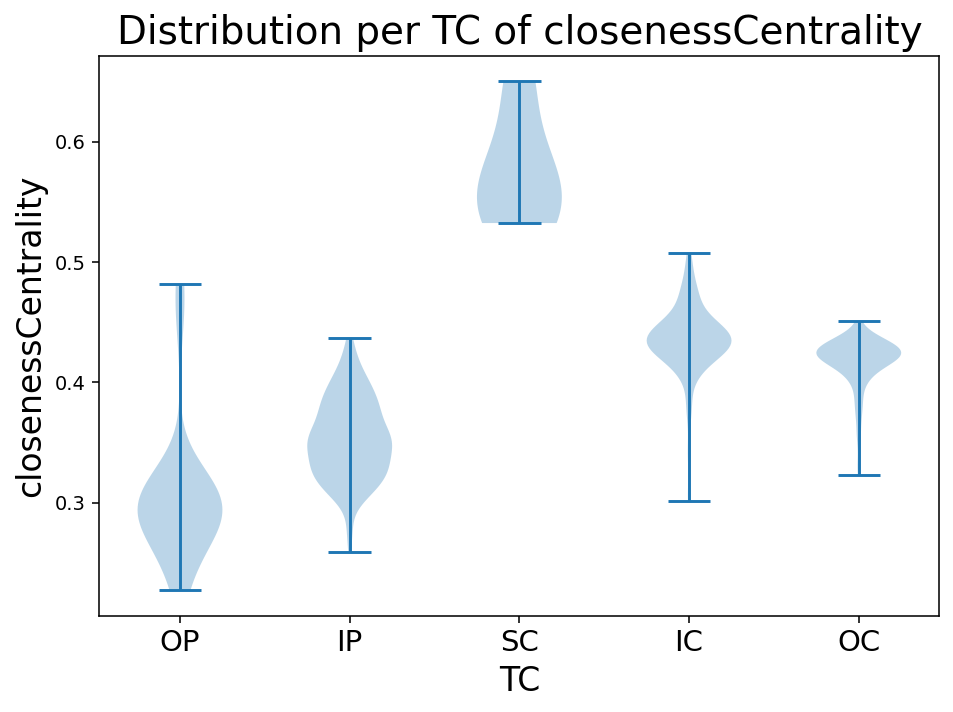

f-value is 239.51146528506575 and p-value is 1.0231806637224042e-113 for closenessCentrality property


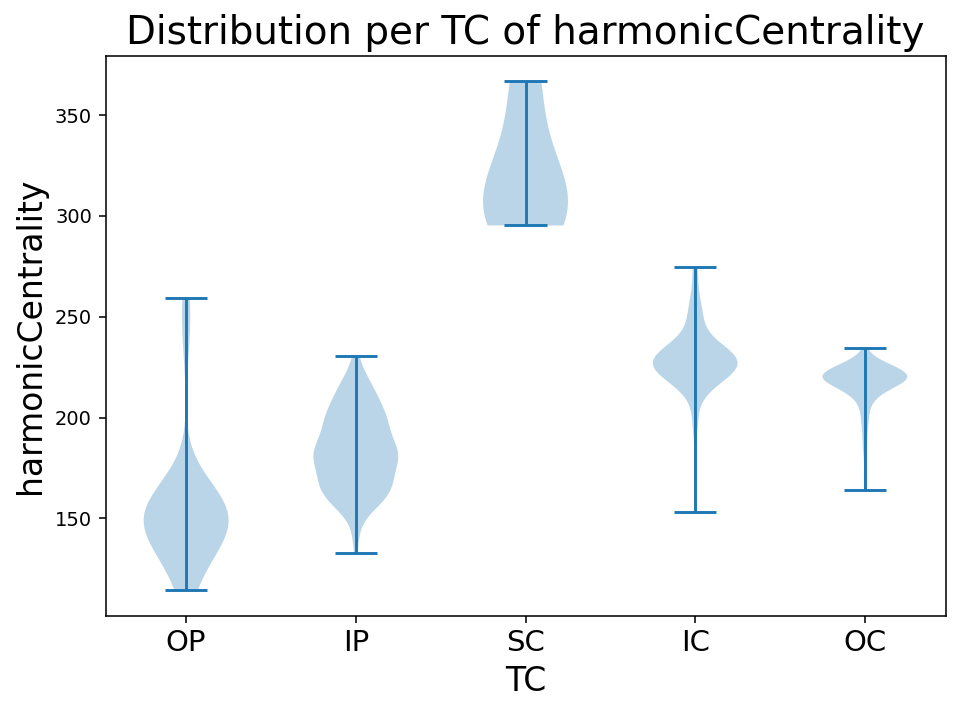

f-value is 226.968564134811 and p-value is 5.609504955223206e-110 for harmonicCentrality property


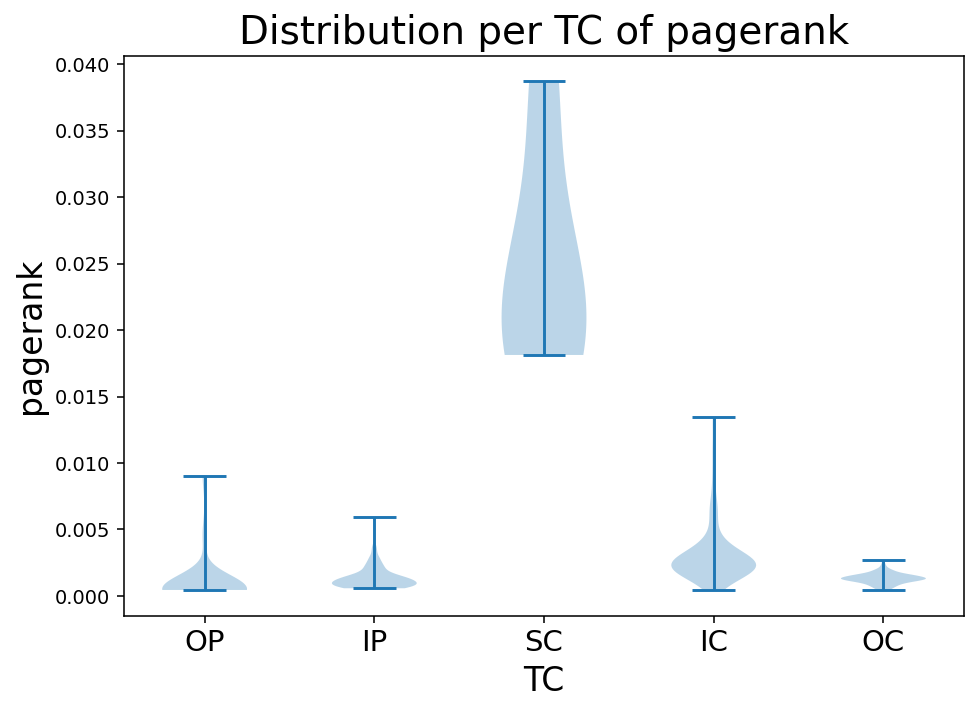

f-value is 307.8677758776853 and p-value is 4.631921596701461e-132 for pagerank property


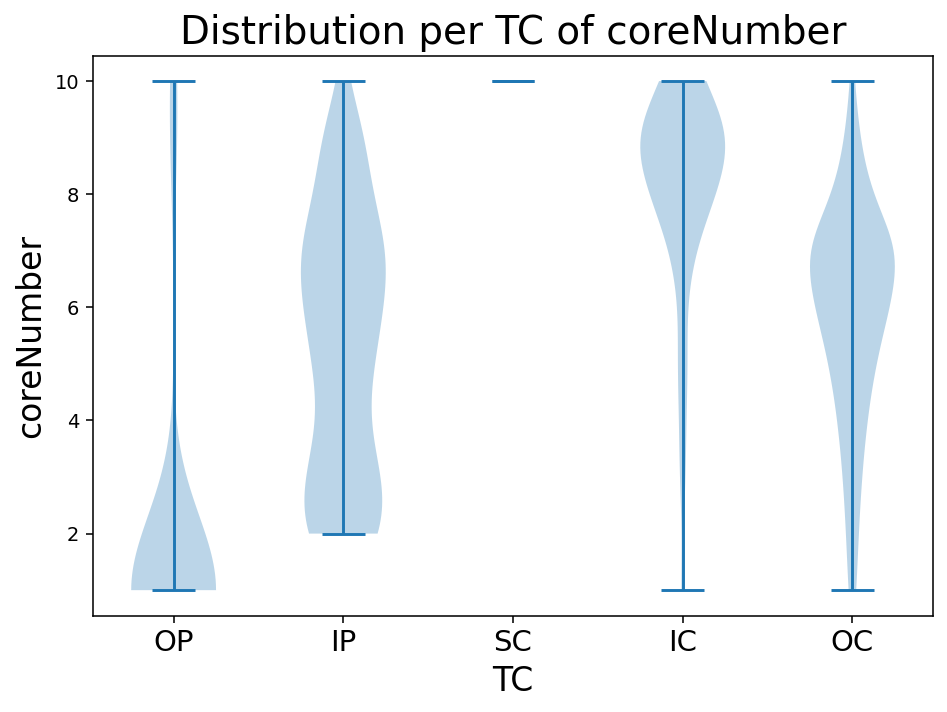

f-value is 66.58139258532614 and p-value is 5.926161015806214e-45 for coreNumber property


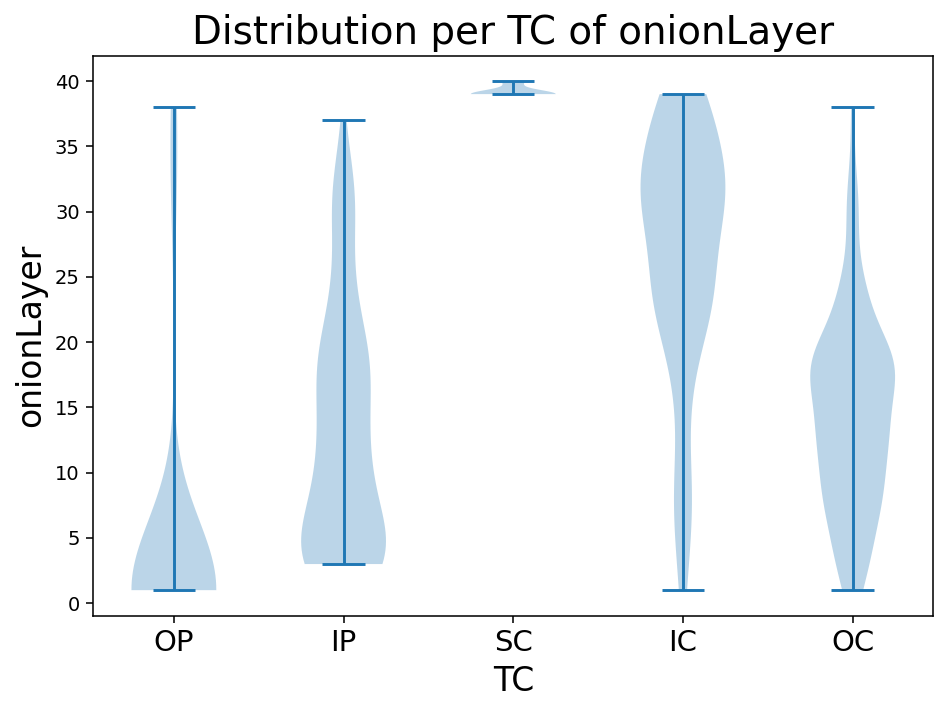

f-value is 72.62100184806432 and p-value is 2.84110780534639e-48 for onionLayer property


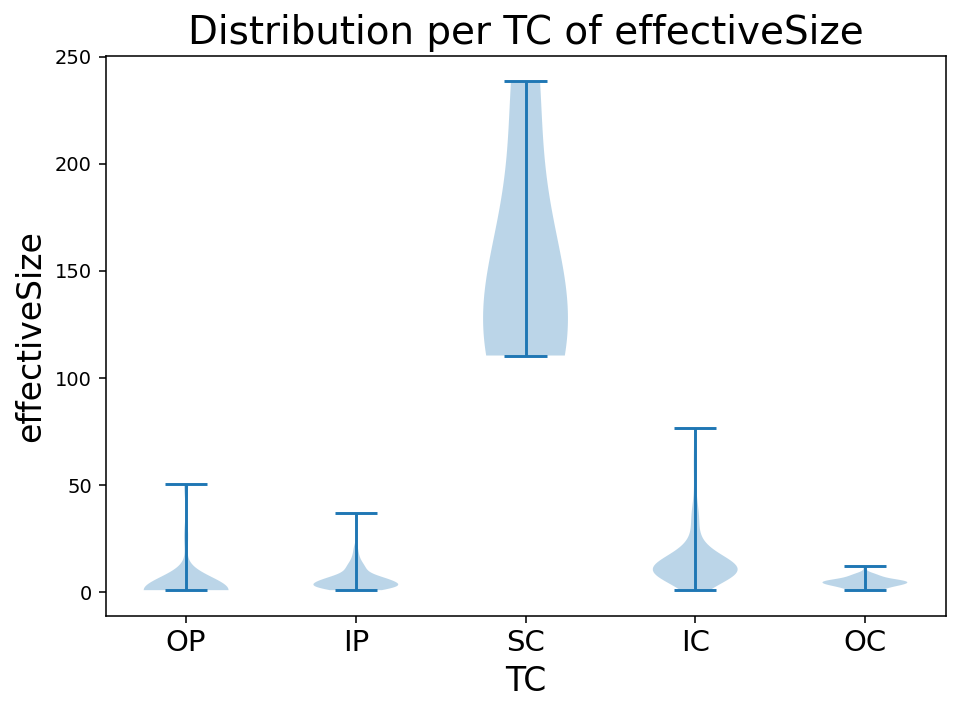

f-value is 313.7187124350245 and p-value is 1.7113825998971178e-133 for effectiveSize property


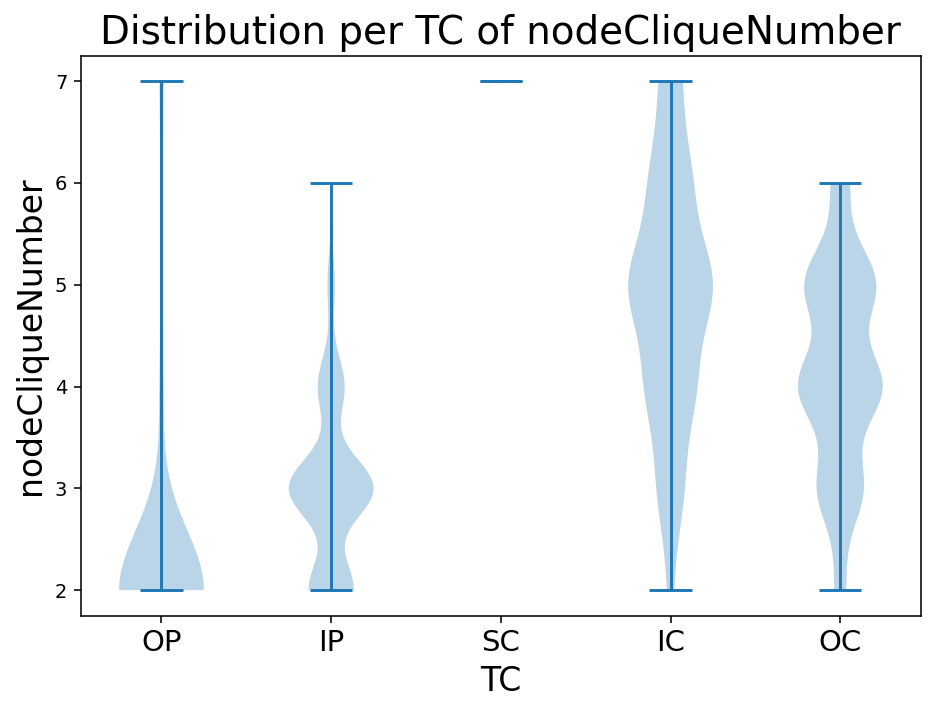

f-value is 94.89491590835097 and p-value is 1.0712053755616549e-59 for nodeCliqueNumber property


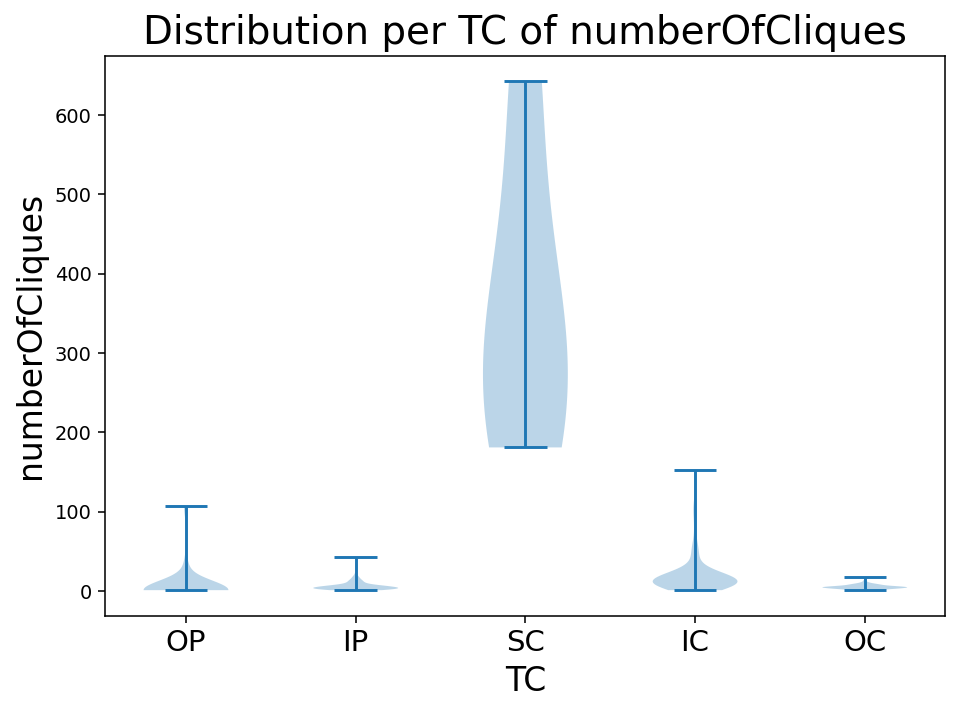

f-value is 312.35328307015385 and p-value is 3.68048787037801e-133 for numberOfCliques property


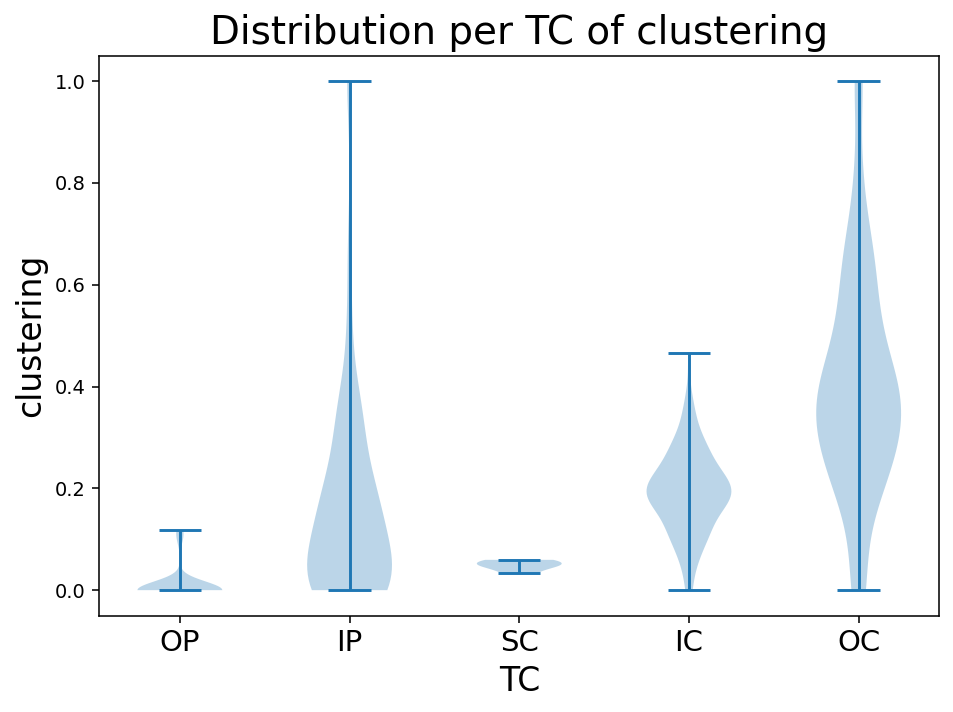

f-value is 53.83264983429332 and p-value is 1.3615309562733668e-37 for clustering property


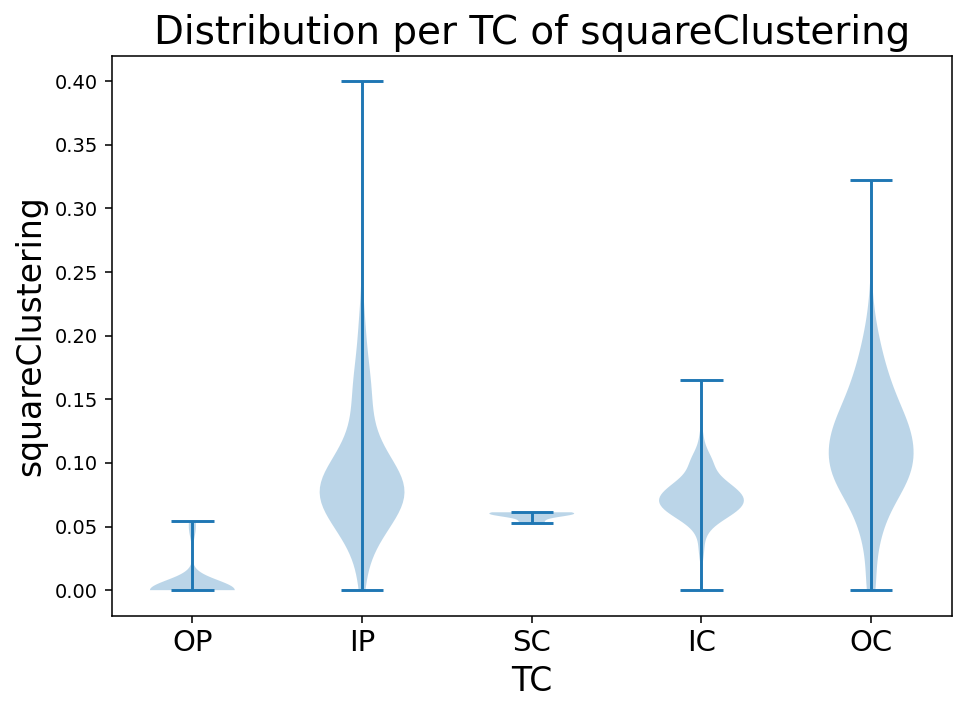

f-value is 37.988476066203035 and p-value is 1.0900753948842134e-27 for squareClustering property


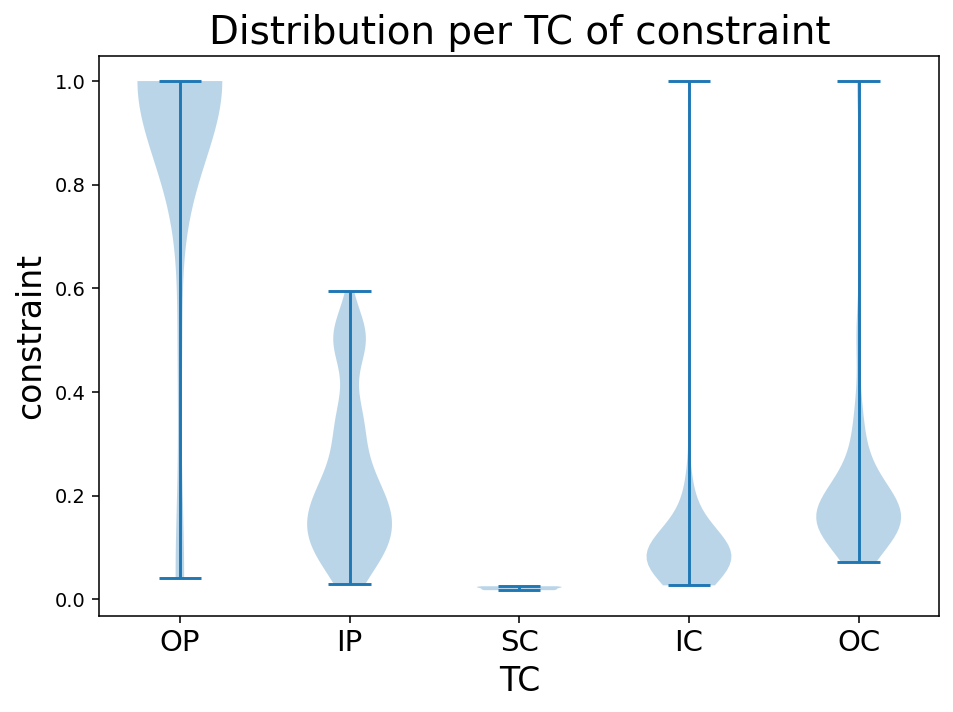

f-value is 131.30115783633548 and p-value is 4.407657671696944e-76 for constraint property


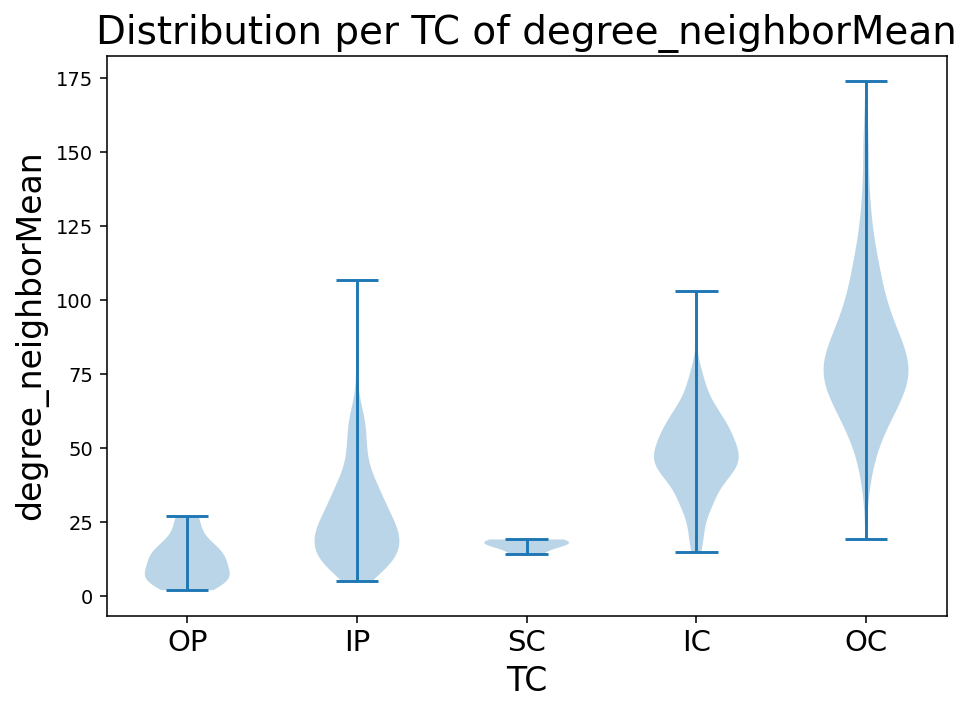

f-value is 228.1472837574188 and p-value is 2.4654852775150582e-110 for degree_neighborMean property


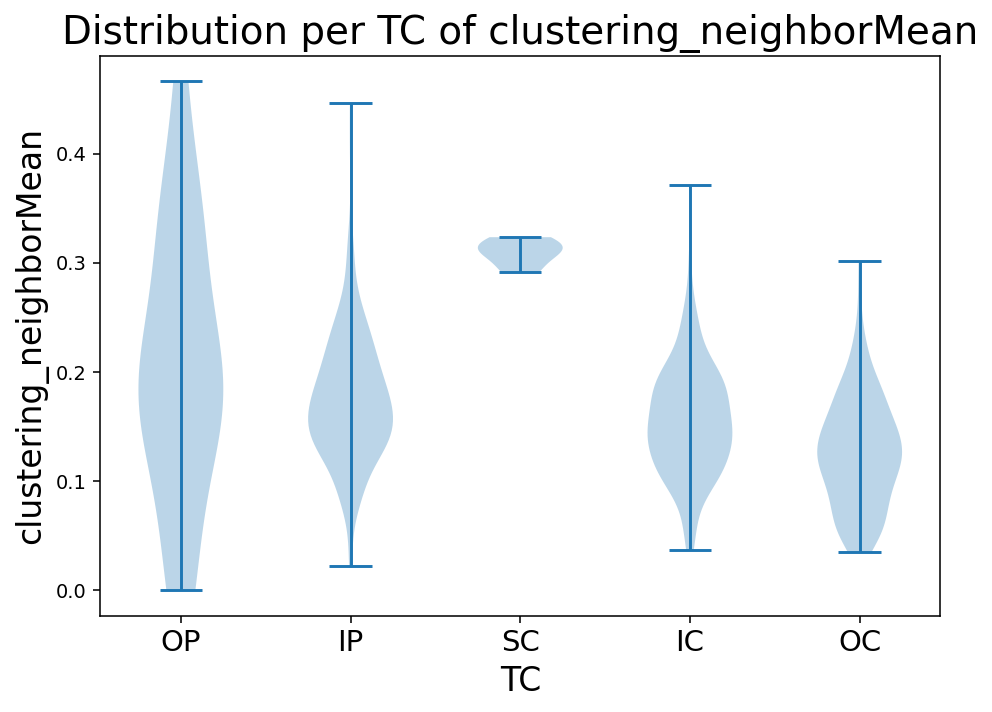

f-value is 26.7261262169063 and p-value is 4.5415988584658064e-20 for clustering_neighborMean property


In [18]:
#same violin plots as before, but know grouping by topological communities, nc= 5 has been chosem
flist = []
plist = []
for key in goodprops.keys():
    prop = goodprops[key]
    zipdict = dict(zip(nodeList,prop))
    orderednodes = dfplot['id_palabra'].to_list()
    dfplot[key] = pd.Series([zipdict[node] for node in orderednodes])
    valuesperpos = []
    topcoms = [i for i in range(1,6,1)]
    for topcom in topcoms:
        values = dfplot[dfplot['nc5'] == topcom][key].to_list()
        valuesperpos.append(values)
    
    labels_tc=['OP','IP','SC','IC','OC']
    fig = plt.figure(dpi=140)
    ax = fig.add_axes([0,0,1,1])
    bp = ax.violinplot(valuesperpos)
    x = np.arange(len(labels_tc)+1)
    plt.xticks(x[1:],labels_tc,size=15)
    plt.title(f'Distribution per TC of {key}',fontsize = 20)
    plt.xlabel('TC', fontsize = 17)
    plt.ylabel(key,fontsize = 17)
    finaldir = picsdir + '/violinpertc'
    if not os.path.exists(finaldir):
        os.mkdir(finaldir)
    plt.savefig(f'{finaldir}/{key}.pdf',bbox_inches = 'tight',dpi = 140)
    plt.show()
    fvalue,pvalue = stats.f_oneway(valuesperpos[0], valuesperpos[1], valuesperpos[2], valuesperpos[3], valuesperpos[4] )
    print(f"f-value is {fvalue} and p-value is {pvalue} for {key} property")
    flist.append(fvalue)
    plist.append(pvalue)
dfvil = pd.DataFrame()
dfvil['prop'] = [prop for prop in goodprops.keys()]   
dfvil['f-value'] = flist
dfvil['p-value'] = plist
dfvil.to_csv('p_f_values_tc.csv')

In [16]:
#Here we are going to study the distribution of words by part of speech through the topological communities
cpertcandpos=dfplot.groupby(by=['nc5','POS']).count()['palabra']
cpertc = dfplot.groupby(by=['nc5']).count()['palabra']
cperpos = dfplot.groupby(by=['POS']).count()['palabra']
dict_cpertc = dict(cpertc)
dict_cperpos = dict(cperpos)
dict_cpertcandpos= dict(cpertcandpos)
#dict_fracposovertc tells us the fraction that a particular part of speech represents across all other POS in a particular TC
dict_fracposovertc = {key:(dict_cpertcandpos[key]/dict_cpertc[key[0]]) for key in dict_cpertcandpos} 
#dict_fracposoverpos tells us the fraction that a particular part of speech in a particular TC over all words ibelonging to that POS
dict_fracposoverpos = {key:(dict_cpertcandpos[key]/dict_cperpos[key[1]]) for key in dict_cpertcandpos}


In [17]:
def plot_fractions_per_tc(fracposoverpos, fracposovertc, labels,tc, path):
    fig, ax = plt.subplots()
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    rects1 = ax.bar(
        x - width / 2, fracposoverpos,edgecolor = 'black', width = width, label="frac POS over all words", color='#0b8eab'
    )
    rects2 = ax.bar(
        x + width / 2, fracposovertc,edgecolor = 'black', width = width, label="frac over TC", color='#ffc152'
    )

    plt.ylabel("Relative frequency", fontsize=12)
    plt.title(f"Distribution of POS tags across TC {tc}")
    #ax.set_xticks(x, labels)
    ax.legend()

    '''
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    '''

    plt.xticks(x, labels,fontsize = 8)
    #plt.yticks(fontsize=12)
    plt.show()
    plt.savefig(path, dpi=200, bbox_inches = 'tight')
    #plt.close(fig)

In [60]:
def plot_fractions_per_pos(fractcoverpos,fractcoverwords,labels,pos, path):
    fig, ax = plt.subplots(dpi=150)
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    rects1 = ax.bar(
        x + width / 2 , fractcoverpos,edgecolor = 'black', width = width, label="frac over POS", color='#ffc152'
    )
    rects2 = ax.bar(
        x - width / 2, fractcoverwords,edgecolor = 'black', width = width, label="frac TC over words", color='#0b8eab'
    )

    plt.ylabel("Relative frequency", fontsize=14)
    plt.title(f"Distribution of {pos} POS tag across TCs", fontsize = 20)
    #ax.set_xticks(x, labels)
    ax.legend(fontsize = 13)

    '''
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    '''

    plt.xticks(x, labels,size = 14)
    plt.xlabel("Topological community")
    #plt.yticks(fontsize=12)
    
    plt.savefig(path, dpi=150,bbox_inches = 'tight')
    #plt.close(fig)

In [33]:
def plot_entropy(entropy,labels,tag,path):
    fig,ax = plt.subplots(dpi = 150)
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    rects1 = ax.bar(
        x , entropy,edgecolor = 'black', width = width, color='#0b8eab'
    )
    

    plt.ylabel("Entropy", fontsize=14)
    plt.title(f"Distribution of entropy {tag}",fontsize = 20)
    #ax.set_xticks(x, labels)


    '''
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    '''

    plt.xticks(x, labels,fontsize = 14,rotation = 90)
    plt.savefig(path, dpi=150,bbox_inches = 'tight')

In [20]:
#Rel frequency of POS vs. all words will be calculated to see the real importance of each pos tag in each topology
rel_freq_pos_over_total = dict((dfplot.groupby(by='POS').count()['palabra']/len(dfplot)).transpose())
rel_freq_pos_over_total

{'ADJ': 0.08704453441295547,
 'ADP': 0.03643724696356275,
 'ADV': 0.0708502024291498,
 'AUX': 0.0465587044534413,
 'CCONJ': 0.012145748987854251,
 'DET': 0.0708502024291498,
 'NOUN': 0.3582995951417004,
 'NUM': 0.024291497975708502,
 'PART': 0.004048582995951417,
 'PRON': 0.09109311740890688,
 'PROPN': 0.1194331983805668,
 'SCONJ': 0.01417004048582996,
 'VERB': 0.06477732793522267}

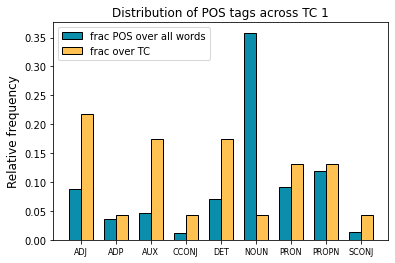

<Figure size 432x288 with 0 Axes>

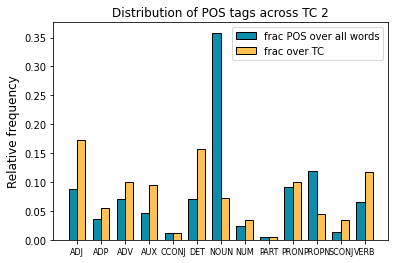

<Figure size 432x288 with 0 Axes>

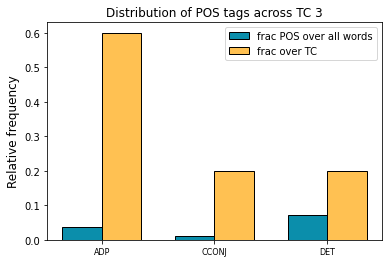

<Figure size 432x288 with 0 Axes>

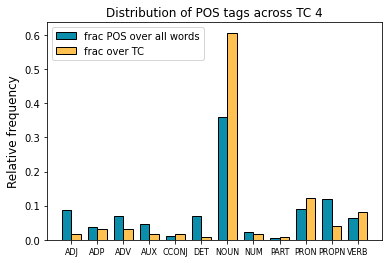

<Figure size 432x288 with 0 Axes>

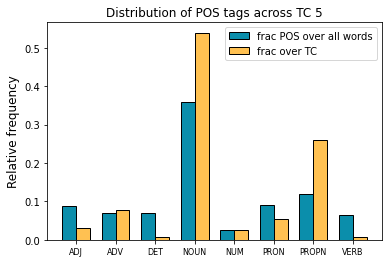

sum of entropy H is 8.064907861535492


<Figure size 432x288 with 0 Axes>

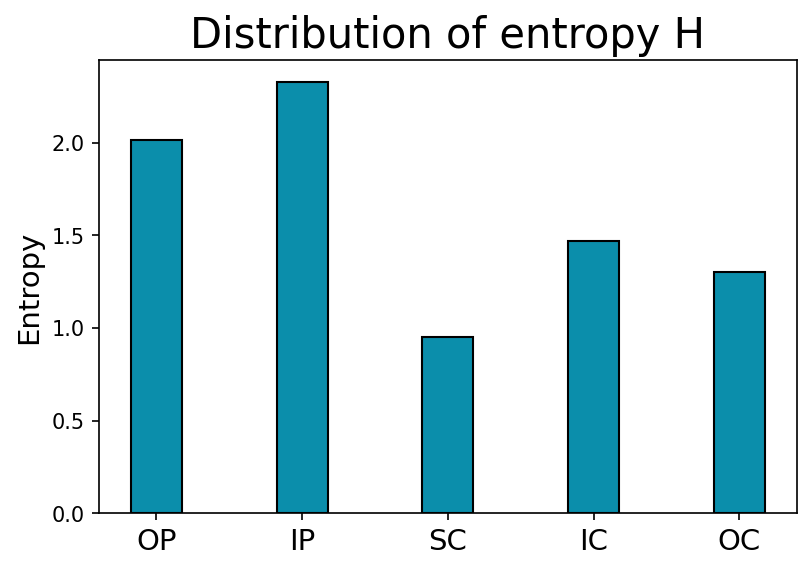

In [32]:
entropy_H = []
for tc in range(1,6,1):
    list_fracposovertc = []
    list_fracposoverpos = []
    list_relfreposovertotal = []
    list_labelpos = []
    for key in dict_fracposovertc.keys():
        if tc == key[0]:
            pos = key[1]
            list_fracposovertc.append(dict_fracposovertc[key])
            list_fracposoverpos.append(dict_fracposoverpos[key])
            list_labelpos.append(pos)
            list_relfreposovertotal.append(rel_freq_pos_over_total[key[1]])
    finaldir = picsdir+'/posacrosstc'
    if not os.path.exists(finaldir):
        os.mkdir(finaldir)
    path = f'{finaldir}/tc{tc}.pdf'
    plot_fractions_per_tc(list_relfreposovertotal, list_fracposovertc, list_labelpos,tc,path)
    entropy_H.append(-np.dot(np.array(list_fracposovertc),np.log(np.array(list_fracposovertc))))
path = f'{finaldir}/entropyH.pdf'
plot_entropy(entropy_H,labels_tc,'H',path)
print(f'sum of entropy H is {sum(entropy_H)}')

sum of entropy S is 11.649023450181346


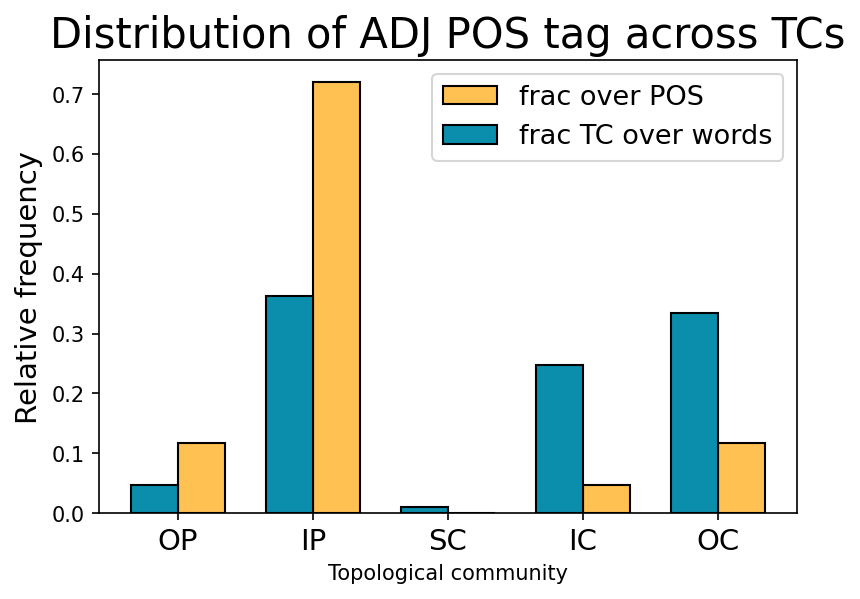

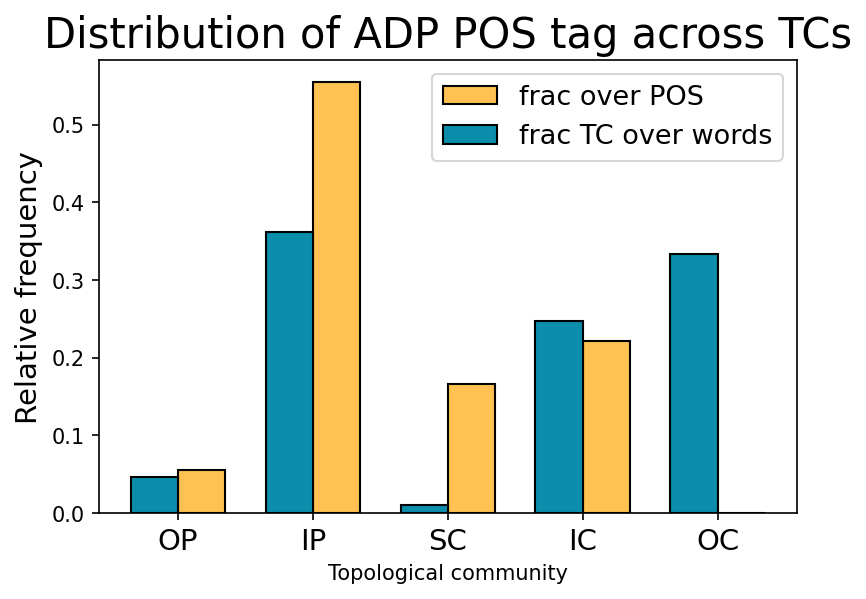

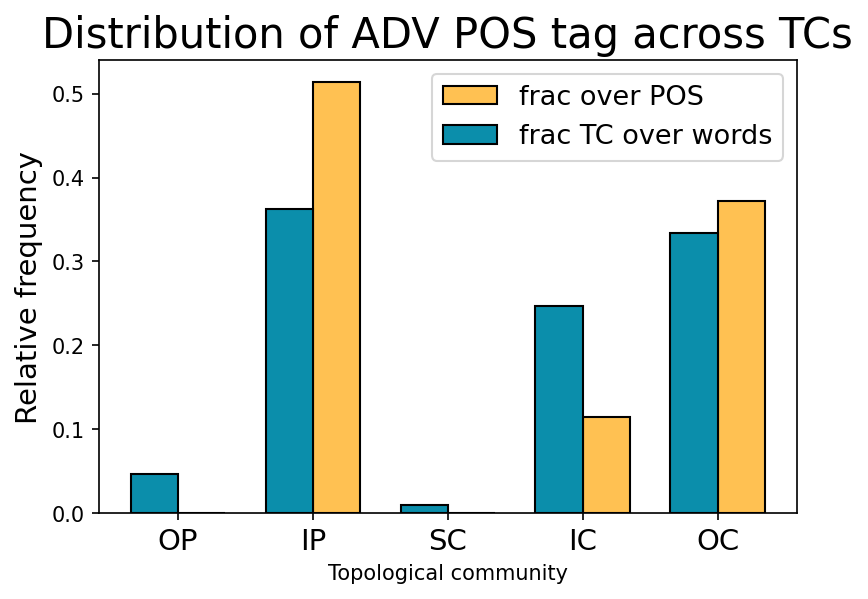

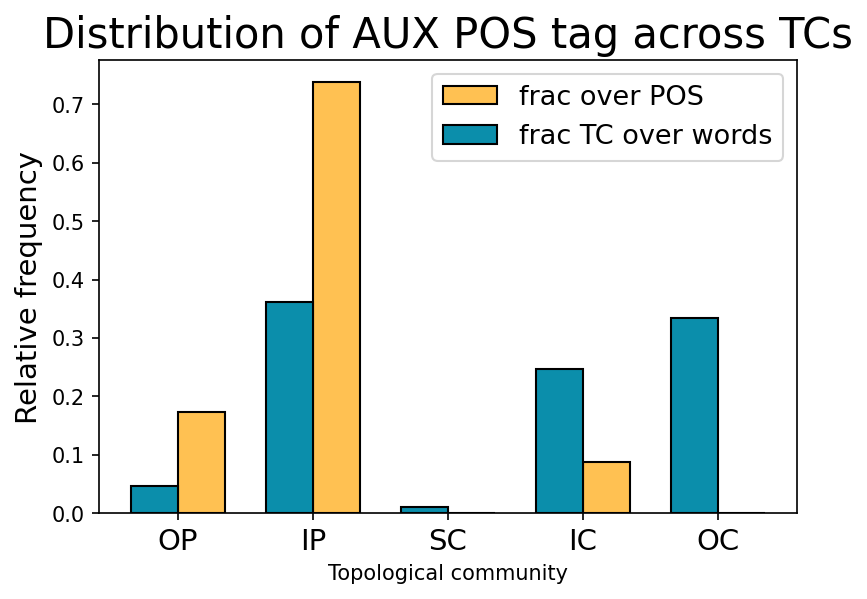

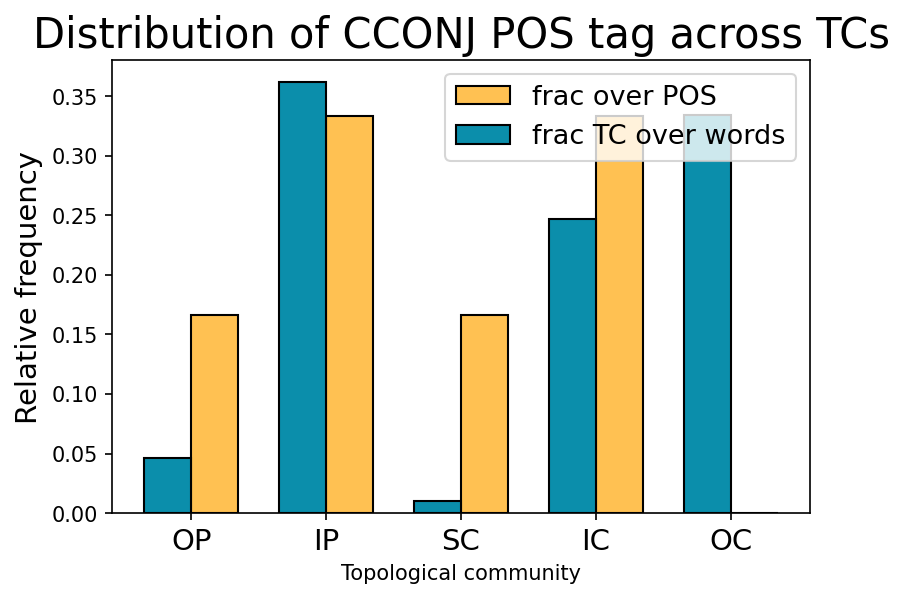

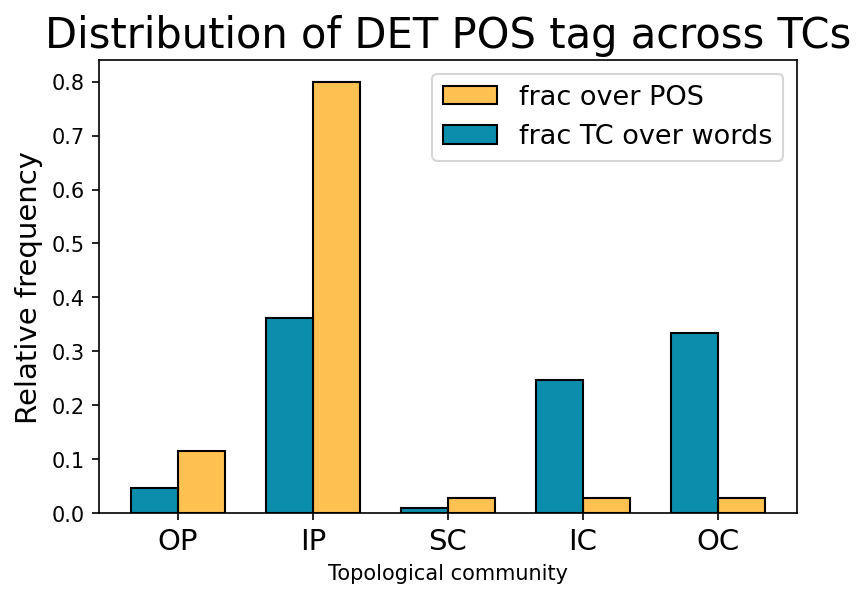

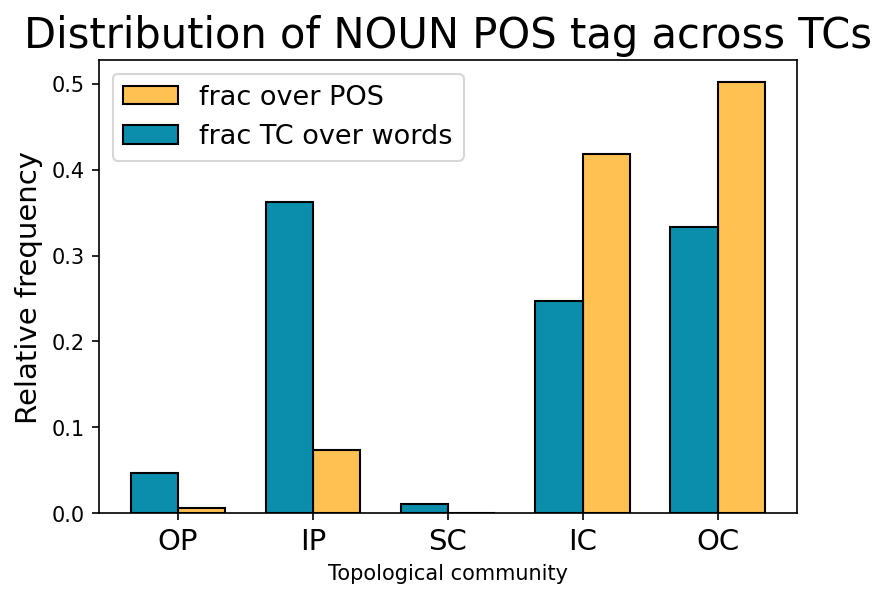

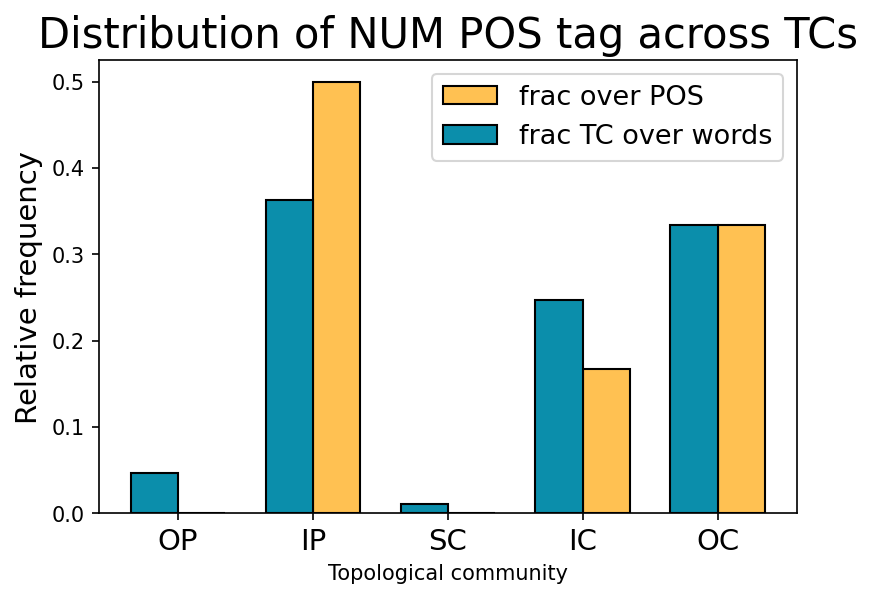

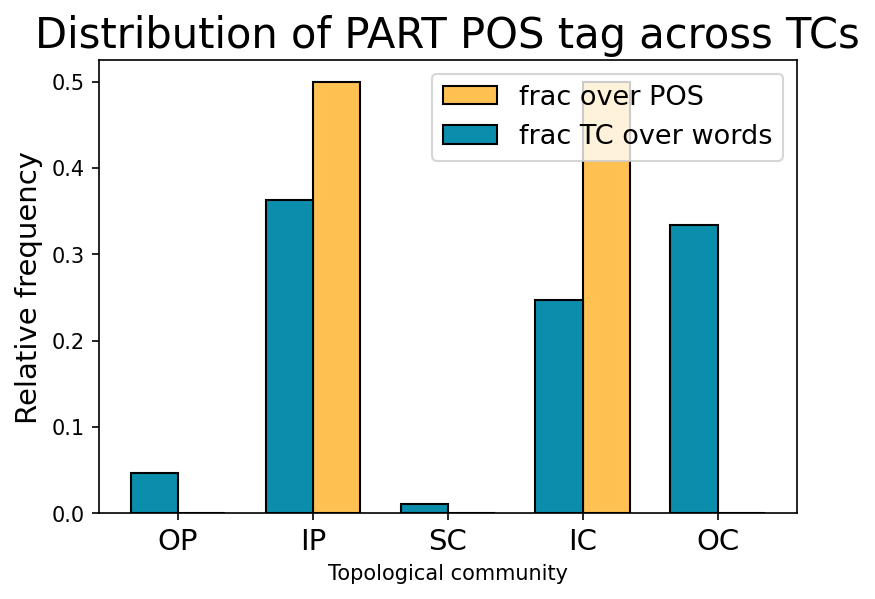

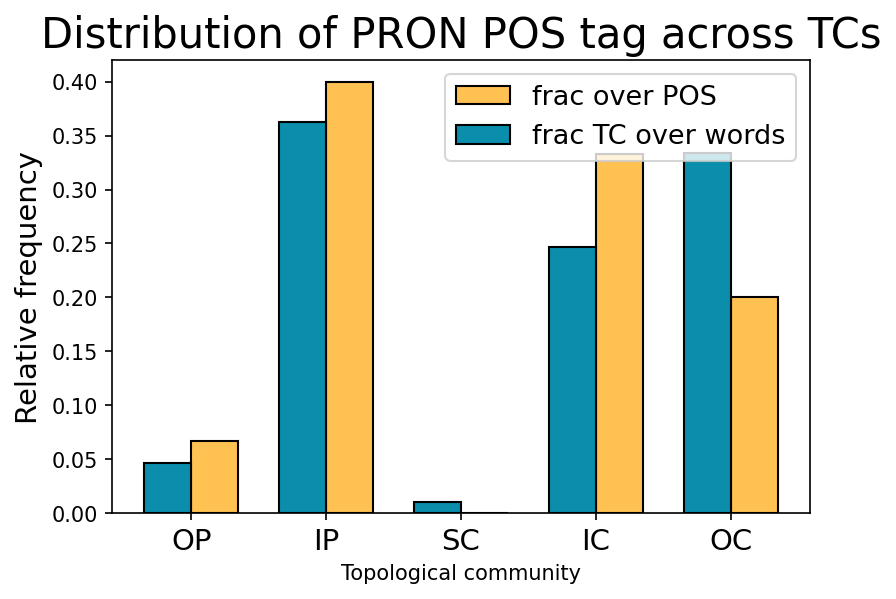

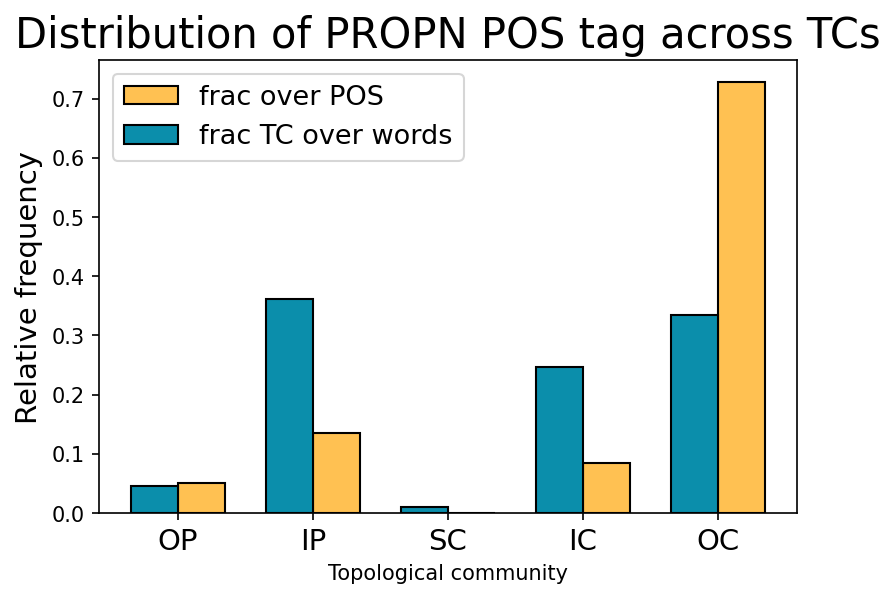

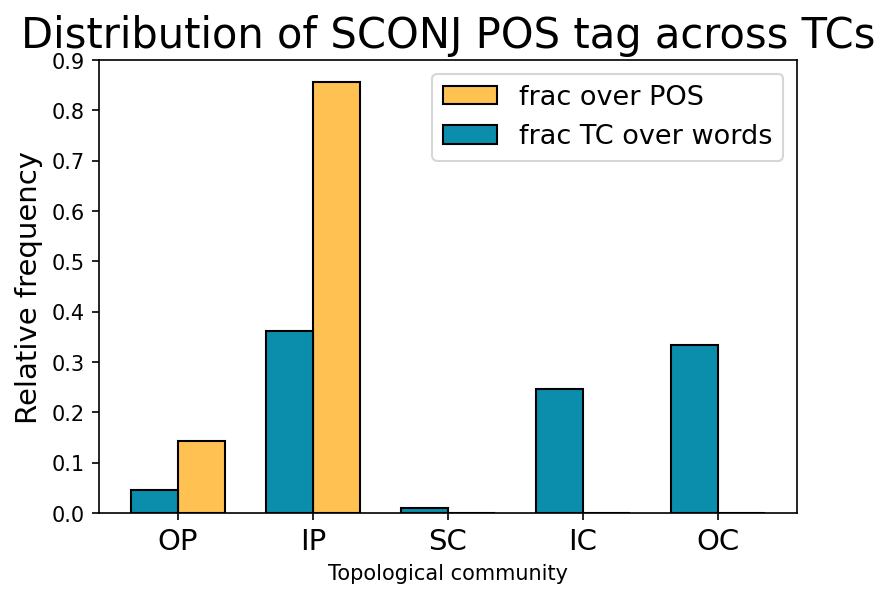

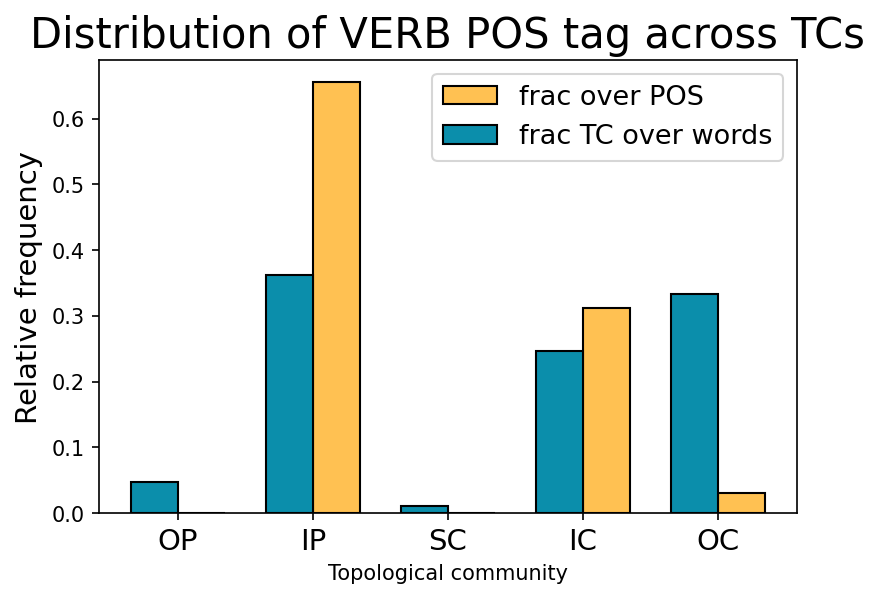

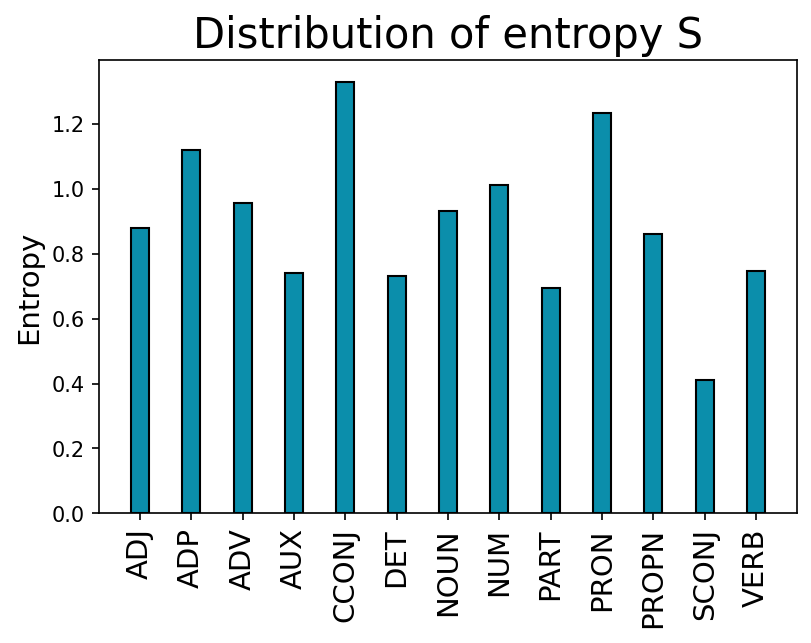

In [61]:
#Now we do the same over each POS tag, to see how they distribute acroos topological communities
entropy_S = []
fractcoverwords = [value/len(dfplot) for value in dict_cpertc.values()] 
df_frac = pd.DataFrame()
df_frac2 = pd.DataFrame()
for tag in postags:
    list_fractcoverpos = []
    total_labels =[str(i) for i in range(1,6,1)]
    list_labelstc = []
    def_frac = [0, 0, 0, 0, 0]
    for key in dict_fracposovertc.keys():
        tc = key[0]
        if tag == key[1]:    
            list_fractcoverpos.append(dict_fracposoverpos[key])
            list_labelstc.append(int(tc))
    for index,value in enumerate(list_labelstc):
        def_frac[value-1] = list_fractcoverpos[index] 
    finaldir = picsdir+'/tcacrosspos'
    if not os.path.exists(finaldir):
        os.mkdir(finaldir)
    path = f'{finaldir}/pos{tag}.pdf'   
    plot_fractions_per_pos(def_frac,fractcoverwords,labels_tc,tag,path)
    entropy_S.append(-np.dot(np.array(list_fractcoverpos),np.log(np.array(list_fractcoverpos))))
    df_frac[tag] = def_frac
    df_frac2[tag] = fractcoverwords
    
path = f'{finaldir}/entropyS.pdf'
plot_entropy(entropy_S,postags,'S',path)
print(f'sum of entropy S is {sum(entropy_S)}')
#df_frac.to_csv('rel_freq.csv')
df_frac2.to_csv('rel_freq2.csv')

            

In [37]:
from utils import json2dict
nodeList = dfplot['id_palabra'].to_list()
#Here we are going to load the dictionary from which the network was orignially created, in order to see the connections each node makes
jsonname = f"files/{iol}/dictionaries/{netName}.json"
connections = json2dict(jsonname, transform_keys=True)
#We filter here since we only want connections from nodes that actually are in the network(top 500 words, 1st gcc)
connections = {key:connections[key] for key in connections if key in nodeList}
#We prepare a dicitionary to map words connected to topologies
dict_palabranc5 = dict(zip(dfplot['id_palabra'].to_list(),dfplot['nc5'].to_list()))
#dict_palabranc5 = {int(key):value for key,value in dict_palabranc5.items()}
dict_palabranc5.keys()
list_connectedtc={}
#Here we form a dictionary storing the number of times each word is connected to each topology, list_conectedtc(This was a mistake, is not a list)
for node in nodeList:
    connections[node] = list(set(connections[node]))
    connections[node] = [id for id in connections[node] if id != node]
    nodesconnected = connections[node]
    topologies = [dict_palabranc5[id] for id in nodesconnected if id in nodeList]
    
    list_connectedtc[node] = (topologies)
#We are going to store the number of times each word is connected to each tc in this variables
cnxnstc1 = []
cnxnstc2 = []
cnxnstc3 = []
cnxnstc4 = []
cnxnstc5 = []
cnxnstotal = []
for node in nodeList:
    cnxnlist = []
    total_connections = len(list_connectedtc[node])
    for i in range(1,6,1):
        list_count_tc = [tc for tc in list_connectedtc[node] if tc == i]
        cnxnlist.append(len(list_count_tc))
    cnxnstc1.append(cnxnlist[0])
    cnxnstc2.append(cnxnlist[1])
    cnxnstc3.append(cnxnlist[2])
    cnxnstc4.append(cnxnlist[3])
    cnxnstc5.append(cnxnlist[4])
    cnxnstotal.append(total_connections)
#Incorporating this data to our df
dfplot['cnxnstc1'] = pd.Series(cnxnstc1)
dfplot['cnxnstc2'] = pd.Series(cnxnstc2)
dfplot['cnxnstc3'] = pd.Series(cnxnstc3)
dfplot['cnxnstc4'] = pd.Series(cnxnstc4)
dfplot['cnxnstc5'] = pd.Series(cnxnstc5)
dfplot['cnxnstotal'] = pd.Series(cnxnstotal)


#list_connectedtc = {key:[dict_palabranc5[node] for node in value] for key,value in connections.items()}
#list_connectedtc

In [38]:
list_connectedtc[12]

[4,
 3,
 3,
 5,
 5,
 4,
 5,
 3,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 2,
 2,
 4,
 4,
 4,
 5,
 4,
 5,
 4,
 2,
 4,
 4,
 5,
 5,
 2,
 2,
 4,
 5,
 4,
 5,
 5,
 4,
 5,
 5,
 4,
 4,
 5,
 2,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 5,
 5,
 5,
 4,
 5,
 4,
 2,
 5,
 4,
 4,
 5,
 5,
 5,
 5,
 4,
 4,
 5,
 5,
 4,
 2,
 5,
 5,
 5,
 5,
 5,
 2,
 5,
 5,
 4,
 5,
 5,
 4,
 5,
 4,
 5,
 5,
 5,
 2,
 5,
 2,
 5,
 2,
 4,
 2,
 4,
 5,
 4,
 2,
 5,
 5,
 4,
 2,
 2,
 2,
 4]

In [39]:
#Calculating frequencies of connection to each community
dfplot['rel_cnxnstc1'] = dfplot['cnxnstc1']/dfplot['cnxnstotal']
dfplot['rel_cnxnstc2'] = dfplot['cnxnstc2']/dfplot['cnxnstotal']
dfplot['rel_cnxnstc3'] = dfplot['cnxnstc3']/dfplot['cnxnstotal']
dfplot['rel_cnxnstc4'] = dfplot['cnxnstc4']/dfplot['cnxnstotal']
dfplot['rel_cnxnstc5'] = dfplot['cnxnstc5']/dfplot['cnxnstotal']

In [40]:
#making sure are number of connections to topologies equals the degree of each node
dfplot[dfplot['cnxnstotal']==dfplot['degree']][['id_palabra','cnxnstc1','cnxnstc2','cnxnstc3','cnxnstc4','cnxnstc5','cnxnstotal','degree','rel_cnxnstc1','rel_cnxnstc2','rel_cnxnstc3','rel_cnxnstc4','rel_cnxnstc5']]

id_palabra  cnxnstc1  cnxnstc2  cnxnstc3  cnxnstc4  cnxnstc5  cnxnstotal  \
0             3         0         0         3        99       145         247   
1            12         0        17         3        49        54         123   
2             5         0        25         2        46        43         116   
3            16         0         9         4        70        91         174   
4            33         0        14         4        61        59         138   
..          ...       ...       ...       ...       ...       ...         ...   
489        2430         0         1         0         4         2           7   
490        5041         0         0         0         1         0           1   
491        3424         0         0         0         1         1           2   
492        3230         0         0         3         3         1           7   
493        3327         0         0         2         2         1           5   

     degree  rel_cnxnstc1  rel_cnxnstc2  rel_cnxnstc3  rel_cnxnstc4  \
0     247.0           0.0      0.000000      0.012146      0.400810   
1     123.0           0.0      0.138211      0.024390      0.398374   
2     116.0           0.0      0.215517      0.017241      0.396552   
3     174.0           0.0      0.051724      0.022989      0.402299   
4     138.0           0.0      0.101449      0.028986      0.442029   
..      ...           ...           ...           ...           ...   
489     7.0           0.0      0.142857      0.000000      0.571429   
490     1.0           0.0      0.000000      0.000000      1.000000   
491     2.0           0.0      0.000000      0.000000      0.500000   
492     7.0           0.0      0.000000      0.428571      0.428571   
493     5.0           0.0      0.000000      0.400000      0.400000   

     rel_cnxnstc5  
0        0.587045  
1        0.439024  
2        0.370690  
3        0.522989  
4        0.427536  
..            ...  
489      0.285714  
490      0.000000  
491      0.500000  
492      0.142857  
493      0.200000  

[494 rows x 13 columns]

In [41]:
#gettin here total connections to each community by POS tag
thickness = dfplot.groupby(by='POS').sum()[['cnxnstc1','cnxnstc2','cnxnstc3','cnxnstc4','cnxnstc5','cnxnstotal']]
#Now getting the frequency of connections to each tc by POS
thickness['rel_cnxnstc1'] = thickness['cnxnstc1']/thickness['cnxnstotal']
thickness['rel_cnxnstc2'] = thickness['cnxnstc2']/thickness['cnxnstotal']
thickness['rel_cnxnstc3'] = thickness['cnxnstc3']/thickness['cnxnstotal']
thickness['rel_cnxnstc4'] = thickness['cnxnstc4']/thickness['cnxnstotal']
thickness['rel_cnxnstc5'] = thickness['cnxnstc5']/thickness['cnxnstotal']


In [42]:
thickness

cnxnstc1  cnxnstc2  cnxnstc3  cnxnstc4  cnxnstc5  cnxnstotal  \
POS                                                                   
ADJ           2        23        22       101        34         182   
ADP           1        68        20       390       409         888   
ADV           1        92        33       133        30         289   
AUX           0        40         8        84        19         151   
CCONJ         1        43         3        69        49         165   
DET           1        54         7       199       110         371   
NOUN         12       545       438       690       250        1935   
NUM           0        16        19        51        20         106   
PART          0        15         5        28         6          54   
PRON          1       181        73       270       110         635   
PROPN         2        53       127       124        57         363   
SCONJ         0        16         0        25         3          44   
VERB          3       144        43       217        66         473   

       rel_cnxnstc1  rel_cnxnstc2  rel_cnxnstc3  rel_cnxnstc4  rel_cnxnstc5  
POS                                                                          
ADJ        0.010989      0.126374      0.120879      0.554945      0.186813  
ADP        0.001126      0.076577      0.022523      0.439189      0.460586  
ADV        0.003460      0.318339      0.114187      0.460208      0.103806  
AUX        0.000000      0.264901      0.052980      0.556291      0.125828  
CCONJ      0.006061      0.260606      0.018182      0.418182      0.296970  
DET        0.002695      0.145553      0.018868      0.536388      0.296496  
NOUN       0.006202      0.281654      0.226357      0.356589      0.129199  
NUM        0.000000      0.150943      0.179245      0.481132      0.188679  
PART       0.000000      0.277778      0.092593      0.518519      0.111111  
PRON       0.001575      0.285039      0.114961      0.425197      0.173228  
PROPN      0.005510      0.146006      0.349862      0.341598      0.157025  
SCONJ      0.000000      0.363636      0.000000      0.568182      0.068182  
VERB       0.006342      0.304440      0.090909      0.458774      0.139535

['rel_cnxnstc1', 'rel_cnxnstc2', 'rel_cnxnstc3', 'rel_cnxnstc4', 'rel_cnxnstc5']


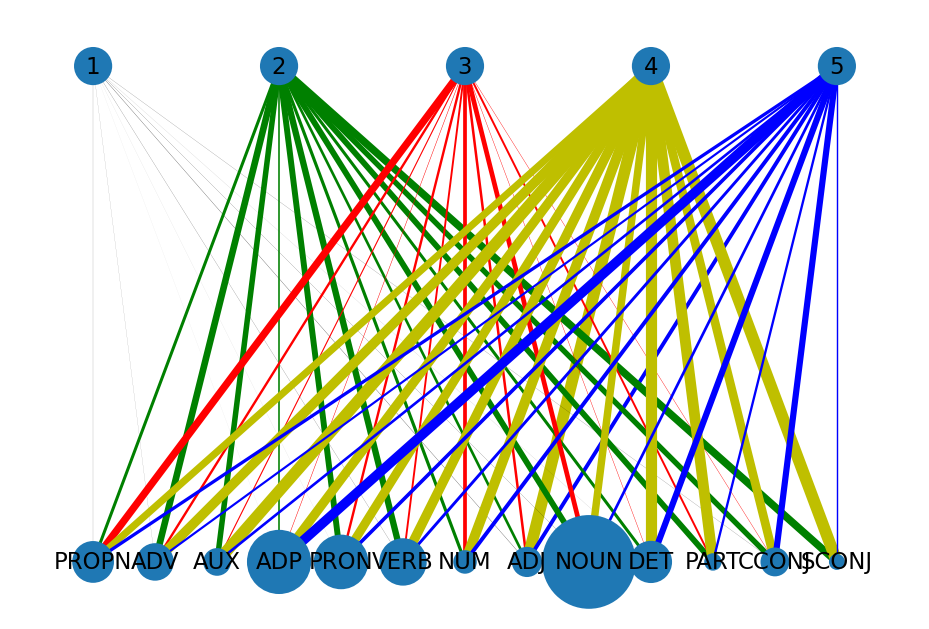

In [56]:
from turtle import color, width
#Using data calculated above to form our bipartite network with edges' width set as relative frequency of connections

thick_plot = thickness[['rel_cnxnstc1','rel_cnxnstc2','rel_cnxnstc3','rel_cnxnstc4','rel_cnxnstc5']]
asd=dict(thick_plot.transpose())
labels = [label for label in asd['ADJ'].index]
print(labels)
dict_conn_thickness ={}
dict_def_thickness = {}
dict_conn ={}
tcs = [1,2,3,4,5]
for key in asd:
    dict_conn_thickness[key] = asd[key].to_list()
    dict_def_thickness[key] = []
    dict_conn[key] = []
    for index,value in enumerate(dict_conn_thickness[key]):
        if value>0:
            dict_conn[key].append(index+1)
            dict_def_thickness[key].append(value)

            
        
g = nx.Graph()
#g.add_nodes_from(dict_def_thickness.keys())
colors = {'ADV':'b','CCONJ':'g','VERB':'r','ADJ':'c',
    'PRON':'m','DET':'y','ADP':'k','PROPN':'w','SCONJ':'tab:purple',
    'NOUN':'tab:orange','NUM':'tab:pink','PART':'tab:brown','AUX':'tab:olive'}
colors2 = ['k','g','r','y','b']
for k in dict_conn.keys():
    for i,v in enumerate(tcs):
        g.add_edge(k,v,color= colors2[i],weight=dict_conn_thickness[k][i]*10)
edges = g.edges()
degrees = dict(thickness['cnxnstotal'].transpose())
minignodelist = [node for node in g.nodes]
list_nodesize = [degrees[key] if key in postags else 300 for key in minignodelist]        
pos = nx.bipartite_layout(g,postags,align = 'horizontal',aspect_ratio=3.5/3)
colors = [g[u][v]['color'] for u,v in edges]
weights = [g[u][v]['weight'] for u,v in edges]
plt.figure(dpi = 150)
nx.draw(g,pos,width=weights, edge_color = colors, node_size = list_nodesize, with_labels = True,font_size=11)
plt.savefig(picsdir+'/networks/posvstc.pdf',bbox_inches = 'tight',dpi = 150)


In [44]:
fractcoverwords

[0.0465587044534413,
 0.3623481781376518,
 0.010121457489878543,
 0.24696356275303644,
 0.3340080971659919]

In [45]:
#gettin here total connections to each community by TC
thickness_tc = dfplot.groupby(by='nc5').sum()[['cnxnstc1','cnxnstc2','cnxnstc3','cnxnstc4','cnxnstc5','cnxnstotal']]
#Now getting the frequency of connections to each tc by TC
thickness_tc['rel_cnxnstc1'] = thickness_tc['cnxnstc1']/thickness_tc['cnxnstotal']
thickness_tc['rel_cnxnstc2'] = thickness_tc['cnxnstc2']/thickness_tc['cnxnstotal']
thickness_tc['rel_cnxnstc3'] = thickness_tc['cnxnstc3']/thickness_tc['cnxnstotal']
thickness_tc['rel_cnxnstc4'] = thickness_tc['cnxnstc4']/thickness_tc['cnxnstotal']
thickness_tc['rel_cnxnstc5'] = thickness_tc['cnxnstc5']/thickness_tc['cnxnstotal']


['rel_cnxnstc1', 'rel_cnxnstc2', 'rel_cnxnstc3', 'rel_cnxnstc4', 'rel_cnxnstc5']


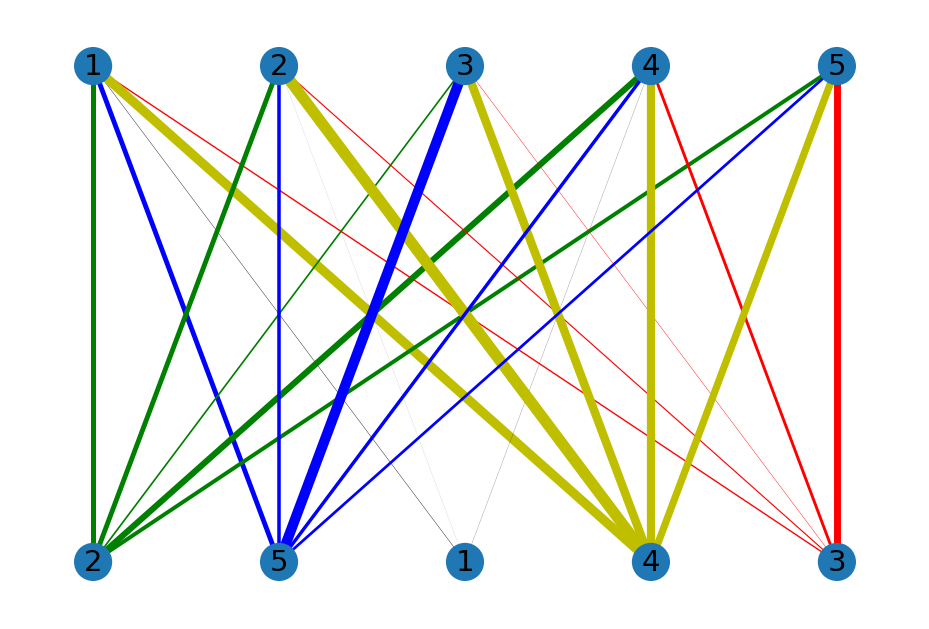

In [52]:
from turtle import color, width
#Using data calculated above to form our bipartite network with edges' width set as relative frequency of connections

thick_plot = thickness_tc[['rel_cnxnstc1','rel_cnxnstc2','rel_cnxnstc3','rel_cnxnstc4','rel_cnxnstc5']]
asd=dict(thick_plot.transpose())
labels = [label for label in asd[1].index]
print(labels)
dict_conn_thickness ={}
dict_def_thickness = {}
dict_conn ={}
tcs = [1,2,3,4,5]
for key in asd:
    dict_conn_thickness[key] = asd[key].to_list()
    dict_def_thickness[key] = []
    dict_conn[key] = []
    for index,value in enumerate(dict_conn_thickness[key]):
        if value>0:
            dict_conn[key].append(index+1)
            dict_def_thickness[key].append(value)

            
        
g = nx.Graph()
#g.add_nodes_from(dict_def_thickness.keys())
colors = {'ADV':'b','CCONJ':'g','VERB':'r','ADJ':'c',
    'PRON':'m','DET':'y','ADP':'k','PROPN':'w','SCONJ':'tab:purple',
    'NOUN':'tab:orange','NUM':'tab:pink','PART':'tab:brown','AUX':'tab:olive'}
colors2 = ['k','g','r','y','b']
tc_str =['1','2','3','4','5']
for k in asd.keys():
    for i,v in enumerate(tc_str):
        g.add_edge(k,v,color= colors2[i],weight=dict_conn_thickness[k][i]*10)
edges = g.edges()
degrees = dict(thickness['cnxnstotal'].transpose())
minignodelist = [node for node in g.nodes]
list_nodesize = [degrees[key] if key in postags else 300 for key in minignodelist]        
pos = nx.bipartite_layout(g,tc_str,align = 'horizontal',aspect_ratio=3.5/3)
colors = [g[u][v]['color'] for u,v in edges]
weights = [g[u][v]['weight'] for u,v in edges]
plt.figure(dpi = 150)
nx.draw(g,pos,width=weights, edge_color = colors, node_size = list_nodesize, with_labels = True,font_size=14)
plt.savefig(picsdir+'/networks/tcvstc.pdf',bbox_inches = 'tight',dpi = 150)

In [47]:
colorset

[2,
 4,
 5,
 3,
 3,
 4,
 5,
 3,
 4,
 4,
 3,
 4,
 5,
 5,
 4,
 5,
 2,
 5,
 2,
 4,
 3,
 5,
 2,
 1,
 2,
 5,
 5,
 2,
 4,
 4,
 4,
 2,
 4,
 4,
 5,
 4,
 2,
 2,
 4,
 4,
 2,
 2,
 4,
 5,
 5,
 5,
 5,
 1,
 4,
 2,
 4,
 2,
 2,
 4,
 1,
 5,
 2,
 5,
 5,
 4,
 2,
 5,
 4,
 2,
 4,
 4,
 4,
 5,
 5,
 4,
 5,
 4,
 4,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 5,
 4,
 4,
 4,
 4,
 2,
 2,
 5,
 4,
 2,
 5,
 5,
 4,
 2,
 2,
 2,
 5,
 2,
 4,
 4,
 2,
 2,
 4,
 2,
 4,
 2,
 4,
 2,
 4,
 2,
 1,
 2,
 4,
 1,
 4,
 2,
 2,
 5,
 2,
 5,
 4,
 4,
 5,
 5,
 4,
 1,
 4,
 2,
 5,
 4,
 4,
 4,
 2,
 2,
 4,
 5,
 2,
 2,
 4,
 5,
 5,
 5,
 2,
 4,
 5,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 4,
 2,
 5,
 5,
 2,
 5,
 2,
 4,
 5,
 1,
 5,
 2,
 2,
 2,
 2,
 4,
 4,
 2,
 2,
 5,
 5,
 4,
 5,
 4,
 2,
 2,
 2,
 2,
 5,
 2,
 5,
 5,
 2,
 2,
 2,
 5,
 5,
 5,
 4,
 5,
 4,
 4,
 5,
 2,
 5,
 2,
 5,
 4,
 5,
 4,
 1,
 4,
 2,
 1,
 4,
 2,
 4,
 2,
 4,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 2,
 5,
 5,
 5,
 2,
 5,
 1,
 2,
 2,
 5,
 2,
 1,
 5,
 5,
 5,
 2,
 4,
 1,
 4,
 2,
 5,
 2,
 5,
 2,
 4,
